<center>
<h1><u>Predicting Baltimore City (MD) Crimes using SARIMAX and fbProphet model | Time Series Forecasting</u></h1>
<h3>Author: Ola Sanusi, PhD</h3>
</center>

___

# Introduction

___

This project involves using historical crimes data to draw inferences on crime types and crime rates. The goal is to use historical Baltimore City, MD data obtained from [Baltimore Open Data Website](https://data.baltimorecity.gov/datasets/part1-crime-data/data?geometry=-86.354%2C37.108%2C-71.534%2C40.112) to explore the diferent type of crimes occuring in the city at different times of the year. It is important that the Baltimore police department are able to forecast crime rate and types so that they will be able to allocate appropriate resoucres to the right neightborhood and district. The project is two fold (1) identify the most important crimes that need speacial attention by performing exploratory data analysis (EDA) (2) use time series to predict the monthly crime rates for the top 5 or important crimes by resampling the data to cover long term (months ahead) forecasting using (S)ARIMA(X) and fbProphet.

___

## Loading and Preprocessing the Data

___

The crime data (in CSV format) was downloaded from the Baltimore Open Data Website and saved in the data folder.

### Import all libraries

In [2]:

#import all needed libraries and perform any required environment setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from pmdarima.arima import auto_arima
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#configure the plotting style and size
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':100})

#expanding the number of visible columms and rows
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

C:\Users\lanre\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lanre\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\lanre\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load and examine the data

In [3]:
filepath = r"C:\Users\lanre\baltimore_crime\data\raw\Part1_Crime_data.csv"
bpd = pd.read_csv(filepath, low_memory=False)
bpd.head(5)

X              Y  RowID           CrimeDateTime CrimeCode  \
0  1.414739e+06  590642.241552      1  2021/03/25 01:20:20+00        1A   
1  1.414739e+06  590642.241552      2  2021/03/25 01:20:20+00        9S   
2  1.422741e+06  612565.958799      4  2021/03/24 00:08:00+00        4E   
3  1.424244e+06  572215.042971      5  2021/03/24 07:53:00+00        4E   
4  1.422815e+06  601711.904140      6  2021/03/24 21:54:00+00      3AJF   

              Location           Description Inside_Outside   Weapon Post  \
0         0 S CAREY ST              HOMICIDE        Outside  FIREARM  933   
1         0 S CAREY ST              SHOOTING        Outside  FIREARM  933   
2         4900 YORK RD        COMMON ASSAULT              I      NaN  521   
3   400 E PATAPSCO AVE        COMMON ASSAULT              I      NaN  913   
4  2500 GREENMOUNT AVE  ROBBERY - CARJACKING              O  FIREARM  513   

   District    Neighborhood  Latitude  Longitude         GeoLocation  \
0  SOUTHERN    UNION SQUARE   39.2879   -76.6382  (39.2879,-76.6382)   
1  SOUTHERN    UNION SQUARE   39.2879   -76.6382  (39.2879,-76.6382)   
2  NORTHERN  WINSTON-GOVANS   39.3480   -76.6096   (39.348,-76.6096)   
3  SOUTHERN        BROOKLYN   39.2372   -76.6049  (39.2372,-76.6049)   
4  NORTHERN         HARWOOD   39.3182   -76.6095  (39.3182,-76.6095)   

                Premise       VRIName  Total_Incidents  
0                STREET  Tri-District                1  
1                STREET  Tri-District                1  
2  APT/CONDO - OCCUPIED           NaN                1  
3     ROW/TOWNHOUSE-OCC      Brooklyn                1  
4  GAS STATION                    NaN                1

In [4]:
bpd.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331388 entries, 0 to 331387
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                331388 non-null  float64
 1   Y                331388 non-null  float64
 2   RowID            331388 non-null  int64  
 3   CrimeDateTime    331388 non-null  object 
 4   CrimeCode        331388 non-null  object 
 5   Location         329828 non-null  object 
 6   Description      331388 non-null  object 
 7   Inside_Outside   289662 non-null  object 
 8   Weapon           71502 non-null   object 
 9   Post             331044 non-null  object 
 10  District         331044 non-null  object 
 11  Neighborhood     331023 non-null  object 
 12  Latitude         331388 non-null  float64
 13  Longitude        331388 non-null  float64
 14  GeoLocation      331388 non-null  object 
 15  Premise          289418 non-null  object 
 16  VRIName          39343 non-null   obje

### Check for missing values

In [5]:
def missing_values(df):
    """" Function to calculate the number and percent of missing values in a dataframe"""
    if df.isnull().sum().sum() > 0:
        total = df.isnull().sum().sort_values(ascending=False)
        percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
        missing_value = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
        print(f'Total and Percentage of Missing Values:\n {missing_value}')
    else:
        print('No Missing Values found.')

In [6]:
missing_values(bpd)

Total and Percentage of Missing Values:
                   Total    Percent
VRIName          292045  88.127814
Weapon           259886  78.423479
Premise           41970  12.664912
Inside_Outside    41726  12.591283
Location           1560   0.470747
Neighborhood        365   0.110143
Post                344   0.103806
District            344   0.103806
GeoLocation           0   0.000000
Longitude             0   0.000000
Latitude              0   0.000000
X                     0   0.000000
Y                     0   0.000000
Description           0   0.000000
CrimeCode             0   0.000000
CrimeDateTime         0   0.000000
RowID                 0   0.000000
Total_Incidents       0   0.000000


### Drop columns with huge amount of missing values

In [7]:
def drop_missing_cols (df, threshold=0.7):
	""" Drop missing values for columns which have missing values
	rate higher than threshold( default=70%) """
	df = df[df.columns[df.isnull().mean() < threshold]]
	return df

In [8]:
bpd = drop_missing_cols(bpd)

### Drop unneeded columns

In [9]:
#drop columns that are not necssary for this project
cols_drop = ['CrimeCode','Total_Incidents','Post','Inside_Outside','Premise','RowID','X','Y','Latitude','Longitude','GeoLocation']
bpd = bpd.drop(cols_drop, axis=1)
bpd.head(3)

CrimeDateTime      Location     Description  District  \
0  2021/03/25 01:20:20+00  0 S CAREY ST        HOMICIDE  SOUTHERN   
1  2021/03/25 01:20:20+00  0 S CAREY ST        SHOOTING  SOUTHERN   
2  2021/03/24 00:08:00+00  4900 YORK RD  COMMON ASSAULT  NORTHERN   

     Neighborhood  
0    UNION SQUARE  
1    UNION SQUARE  
2  WINSTON-GOVANS

### Deal with remaining missing values

In [10]:
#Fill missing values in the District and Neighborhood with the mode and drop the remaining missing values
bpd['District'] = bpd['District'].fillna(bpd['District'].mode())
bpd['Neighborhood'] = bpd['Neighborhood'].fillna(bpd['Neighborhood'].mode())
bpd =bpd.dropna().reset_index(drop=True)

In [11]:
missing_values(bpd)

No Missing Values found.


___

## Feature Extraction

___

### Format crime date to datetime and set index as datetime


Let's extract time and date features from the Date column.

In [12]:
%%time
#Split Datetime into year, month, day, day name, hour and minute

bpd['Timestamp'] = pd.to_datetime(bpd['CrimeDateTime'], format='%Y-%m-%d %H:%M:%S')
bpd['year'] = bpd['Timestamp'].dt.year
bpd.index = bpd['Timestamp']
bpd.head(3)

Wall time: 666 ms


CrimeDateTime      Location  \
Timestamp                                                         
2021-03-25 01:20:20+00:00  2021/03/25 01:20:20+00  0 S CAREY ST   
2021-03-25 01:20:20+00:00  2021/03/25 01:20:20+00  0 S CAREY ST   
2021-03-24 00:08:00+00:00  2021/03/24 00:08:00+00  4900 YORK RD   

                              Description  District    Neighborhood  \
Timestamp                                                             
2021-03-25 01:20:20+00:00        HOMICIDE  SOUTHERN    UNION SQUARE   
2021-03-25 01:20:20+00:00        SHOOTING  SOUTHERN    UNION SQUARE   
2021-03-24 00:08:00+00:00  COMMON ASSAULT  NORTHERN  WINSTON-GOVANS   

                                          Timestamp  year  
Timestamp                                                  
2021-03-25 01:20:20+00:00 2021-03-25 01:20:20+00:00  2021  
2021-03-25 01:20:20+00:00 2021-03-25 01:20:20+00:00  2021  
2021-03-24 00:08:00+00:00 2021-03-24 00:08:00+00:00  2021

The dataset for 2021 contains only the first three months and data from 1963 to 2013 is very sparse with just few data recorded per year so I decided to exclude data from 1963 to 2013 in addition to 2021. I will be creating a new data from 2014 to 2020 which is 7 years of crime data.

## Subsetting the time series from 2014 to 2020 

In [14]:
bpd = bpd[(bpd['year']>=2014) & (bpd['year']!=2021)] 

## Summary from data preprocessing steps

Seven (7) years of the crime data were considered because of the sparsity of data before 2014 and incompleteness of data in 2021. Important operations performed to preprocess the data include the following:

- Checked for missing values and dropped all columns with missing values greater than 70%
- Dropped columns ('CrimeCode','Total_Incidents','Post','Inside_Outside','Premise','RowID','X','Y') that are not necessary for this project
- Dealt with the remaining missing values by replacing missing values in each column by the mode of the categorical variables and dropped the remaining missing values from the data
- Converted crime date to datetime,and extracted the year
- Set the dataframe index to datetimeindex
- Limit the data to the past 7 years covering 2014 to 2020 due to sparsity of the raw dataset

___

# Exploratory Data Analysis (EDA)

___

The crime data covering a 7 year period (Jan 1, 2014 — Dec 31,  2020) will be used in predicting the crime rates for different crime types occuring in Baltimore. The objective is to predict the crimes for the next (2 years) 90 days for every item at every store.

We won’t be doing much EDA in this article but for just a brief snapshot of what type of data we are dealing with I created a plot of the mean sales per item per day.



### Overall daily crime trend 

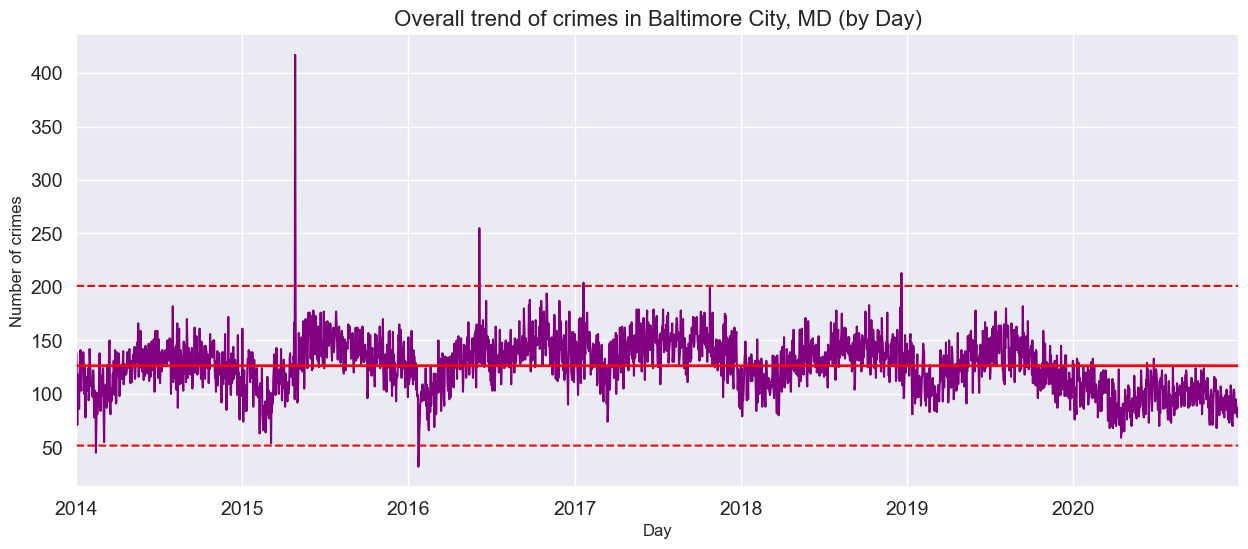

In [15]:
def overall_crime_plot(df):
    # mean and standard deviation of crimes per day
    crimes_per_day = pd.DataFrame(df.resample('D').size())
    crimes_per_day["MEAN"] = df.resample('D').size().mean()
    crimes_per_day["STD"] = df.resample('D').size().std()
    # upper control limit and lower control limit
    UCL = crimes_per_day['MEAN'] + 3 * crimes_per_day['STD']
    LCL = crimes_per_day['MEAN'] - 3 * crimes_per_day['STD']
    plt.figure(figsize=(15,6))
    df.resample('D').size().plot(label='Crimes per day', color='purple')
    UCL.plot(color='red', ls='--', linewidth=1.5, label='UCL')
    LCL.plot(color='red', ls='--', linewidth=1.5, label='LCL')
    crimes_per_day['MEAN'].plot(color='red', linewidth=2, label='Average')
    plt.title('Overall trend of crimes in Baltimore City, MD (by Day)', fontsize=16)
    plt.xlabel('Day')
    plt.ylabel('Number of crimes')
    plt.tick_params(labelsize=14)
    
overall_crime_plot(bpd)

The important information from the monthly crimes in Baltimore City is that the overall crimes is has been decreasing steadily in the past three years.

### Best and worst crime months 

In [16]:
def crime_stats(df):
    month_df = bpd.resample('M').size()
    print("Best Month {0}: {1}".format(month_df.idxmin(), month_df[month_df.idxmin()]))
    print("Worst Month {0}: {1}".format(month_df.idxmax(), month_df[month_df.idxmax()]))
    
crime_stats(bpd)

Best Month 2020-04-30 00:00:00+00:00: 2519
Worst Month 2016-10-31 00:00:00+00:00: 4780


### Crime trend for each crime type

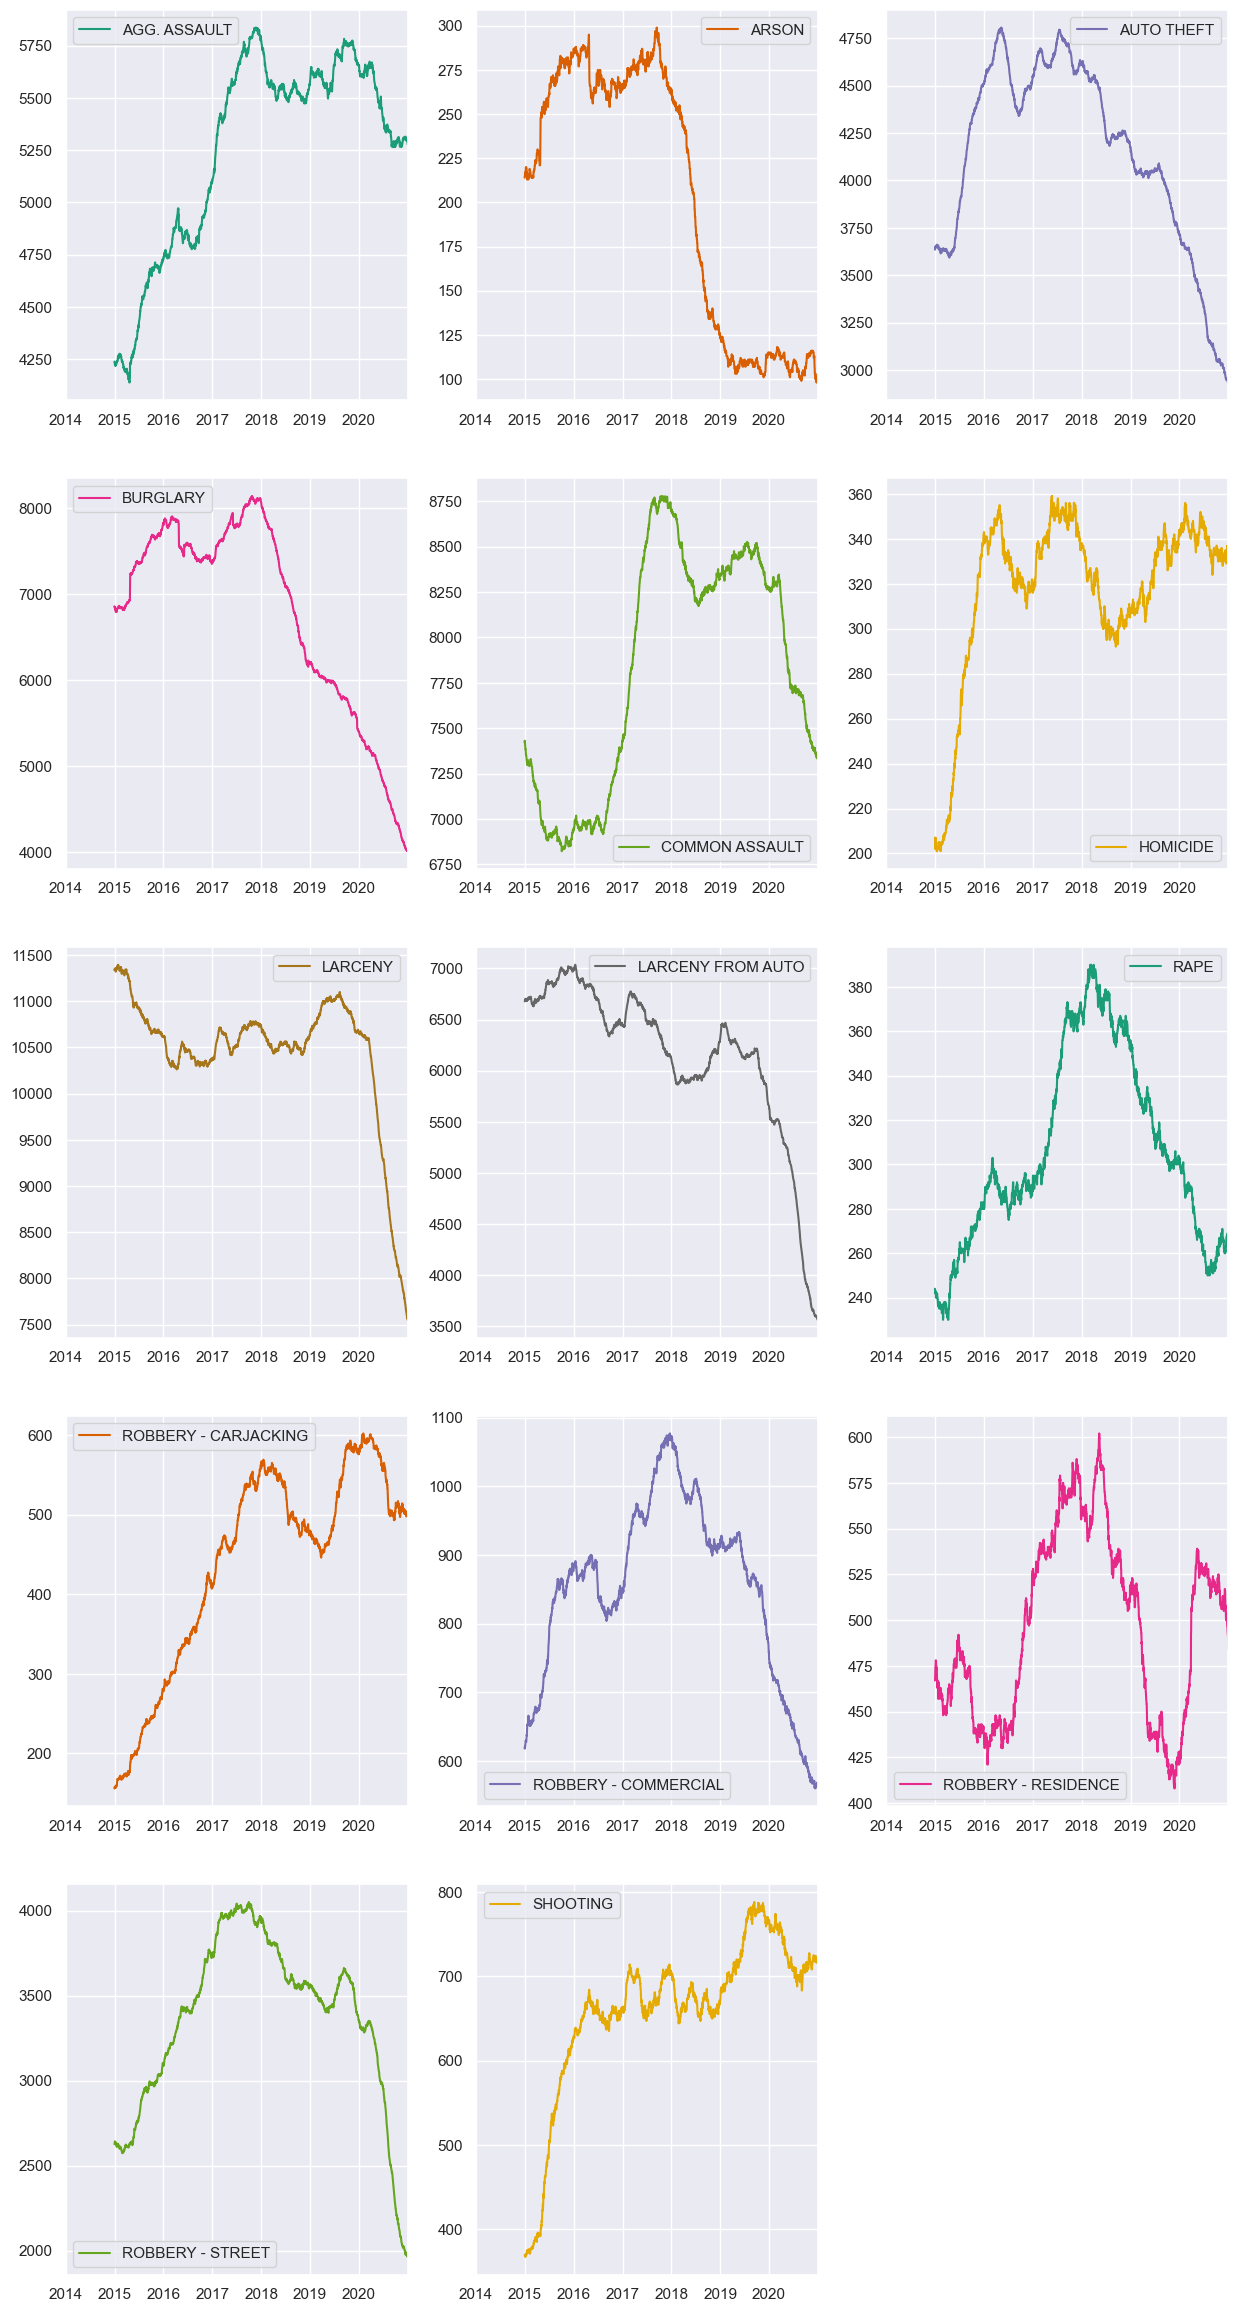

In [18]:
def crime_type_trend(df):
    crimes_count_date=bpd.pivot_table('CrimeDateTime',aggfunc=np.size,columns='Description',index=bpd.index.date,fill_value=0)
    crimes_count_date.index=pd.DatetimeIndex(crimes_count_date.index)
    plot=crimes_count_date.rolling(365).sum().plot(figsize=(15,30),subplots=True,layout=(-1,3),sharex=False,sharey=False)
    
crime_type_trend(bpd)

However, if you look at the trend for each of the crime types. From the above reported crime type trend, only three (homicide, robbery-carjacking and shooting) are showing an increasing trend. The others reveals somewhat decreasing trends from the previous years.

In lieu of this findings, it will be necessary to use time series forecasting to model trends for the following:
- the overall crimes occuring irrespective of types
- all crime types showing increasing trend
    1. homicide
    2. robbery-carjacking
    3. shooting
    
- most important crime types showing decreasing trend
    4. rape
    5. agg.assault

## Build new dataframes for creating a seasonal ARIMA models

In [19]:
%%time
## In order to analyze the specific crime types, new dataframes just for these specific crimes are built. 
crime=bpd.copy()
homicide = crime[crime['Description']=='HOMICIDE']
rape = crime[crime['Description']=="RAPE"]
shooting = crime[crime['Description']== "SHOOTING"]
carjack = crime[crime['Description']=="ROBBERY - CARJACKING"]
assault = crime[crime['Description']=="AGG. ASSAULT"]



Wall time: 186 ms


We first want to visualize the data to understand what type of model we should use. Is there an overall trend in your data that you should be aware of? Does the data show any seasonal trends? This is important when deciding which type of model to use. If there isn’t a seasonal trend in your data, then you can just use a regular ARIMA model instead. If you are using daily data for your time series and there is too much variation in the data to determine the trends, you might want to look at resampling your data by month, or looking at the rolling mean.

___

## Time-series seasonal decomposition

___

In [20]:
def decompose_dataframe(df):
    y = df.resample ('MS').size ()
    decomposition = sm.tsa.seasonal_decompose(y, model='additive')
    fig = decomposition.plot()
    fig.set_figheight(8)
    plt.show()

**Overall Crime Decomposition**

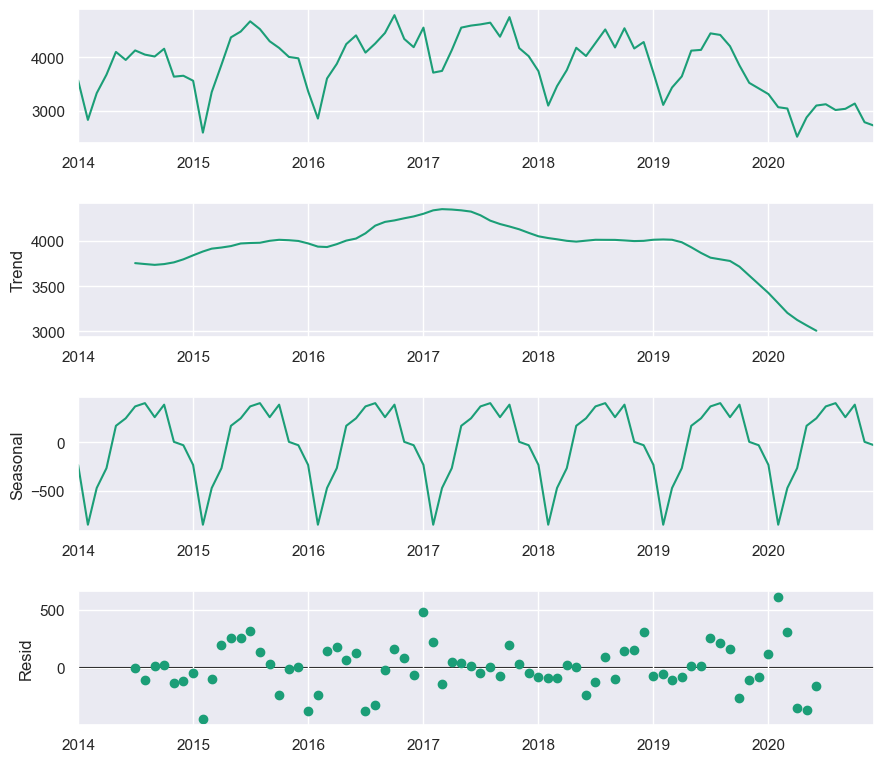

In [21]:
decompose_dataframe(crime)

## Test for stationarity

In [22]:
def resampled(df):
    """ resample the data into montly data"""
    y = df.resample ('MS').size()
    return y

In [23]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    """ function to perform the Dickey-Fuller test and plot the time series"""
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]                   
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        if p_value <= 0.05:
            print('Time Series is Stationary')
        else:
            print('Time Series is NOT Stationary')

Time Series is NOT Stationary


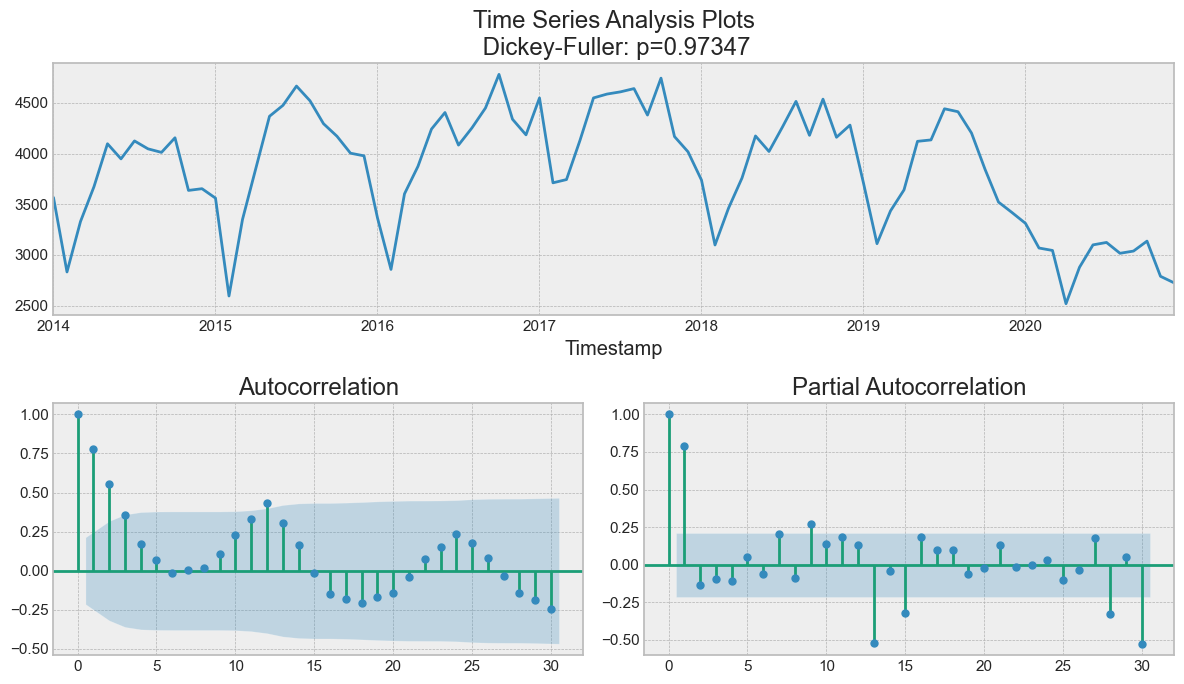

In [24]:
# test for stationarity of overall data
tsplot(resampled(crime), lags=30)


60 24


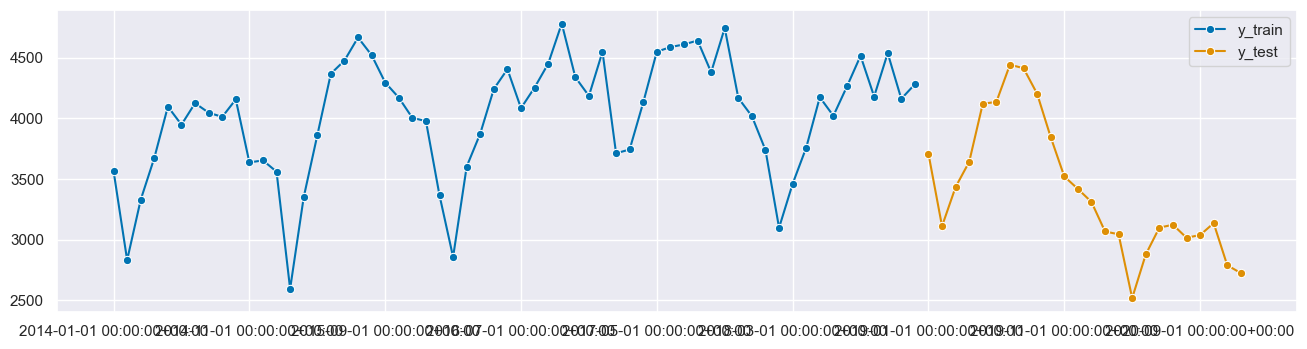

In [25]:

y_train, y_test = temporal_train_test_split(resampled(crime), test_size=24)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

We will try to predict the last 2 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 24 points as test data, and use 24-step ahead forecasting horizon to evaluate forecasting performance.

## **Using Pyramid Arima to determine the optimal SARIMAX parameters**

In [26]:
sarimax_model = auto_arima(y_train, start_p=1, d=1, start_q=1, max_p=8, max_d=2, max_q=8, 
                        start_P=0, D=None, start_Q=0, max_P=8, max_D=1, max_Q=8, 
                        m=12, seasonal=True, stationary=False, 
                        information_criterion='aic', alpha=0.05, test='kpss', 
                        seasonal_test='ocsb', stepwise=True, n_jobs=-1, 
                        start_params=None, trend=None, method='lbfgs', 
                        maxiter=50, offset_test_args=None, seasonal_test_args=None, 
                        suppress_warnings=True, error_action='warn', trace=False, 
                        random=False, random_state=500, n_fits=30)

In [27]:
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -411.837
Date:                              Thu, 26 Aug 2021   AIC                            835.673
Time:                                      17:01:11   BIC                            848.138
Sample:                                           0   HQIC                           840.539
                                               - 60                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5390      2.612     -0.206      0.836      -5.658       4.580
ar.L1         -0.1907      0.128     -1.492      0.136      -0.441       0.060
ar.L2         -0.2523      0.130     -1.941      0.052      -0.507       0.002
ar.S.L12       0.9802      0.071     13.720      0.000       0.840       1.120
ma.S.L12      -0.7178      0.458     -1.567      0.117      -1.616       0.180
sigma2      4.654e+04      2e+04      2.328      0.020    7355.482    8.57e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.69   Prob(JB):                         0.73
Heteroskedasticity (H):               0.50   Skew:                            -0.20
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**So the best model as per the auto arima is Sarimax(2,1,0)(1,0,1)(12). Now that we have our recommended orders we can run our model.**

## The SARIMAX paramters for overall crimes SARIMAX(2, 1, 0)x(1, 0, [1], 12)

### Fitting the SARAMAX model

In [28]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(2, 1, 0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()


In [29]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -308.103
Date:                              Thu, 26 Aug 2021   AIC                            626.205
Time:                                      17:02:05   BIC                            635.238
Sample:                                  01-01-2014   HQIC                           629.573
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2471      0.155     -1.590      0.112      -0.552       0.057
ar.L2         -0.23

**After we have fitted the model to the data, we check the residual plots to verify the validity of the model fit. A good forecasting method will have minimal information left in the residuals if any**

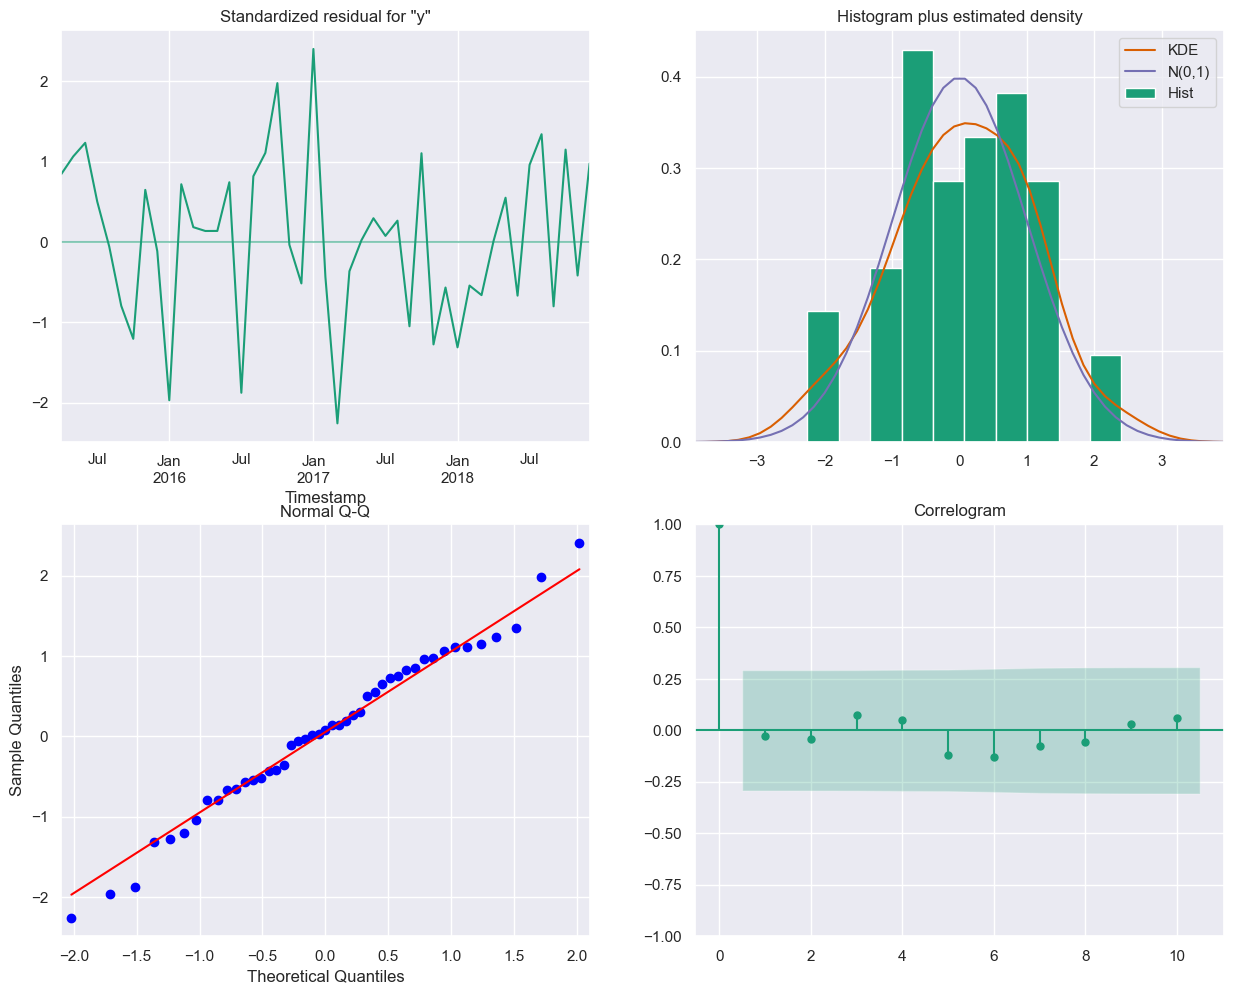

In [30]:
#Diagnosing the model residuals
results.plot_diagnostics(figsize=(15,12));

From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. Also, the correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise. Therefore, these residuals are uncorrelated and have zero mean.

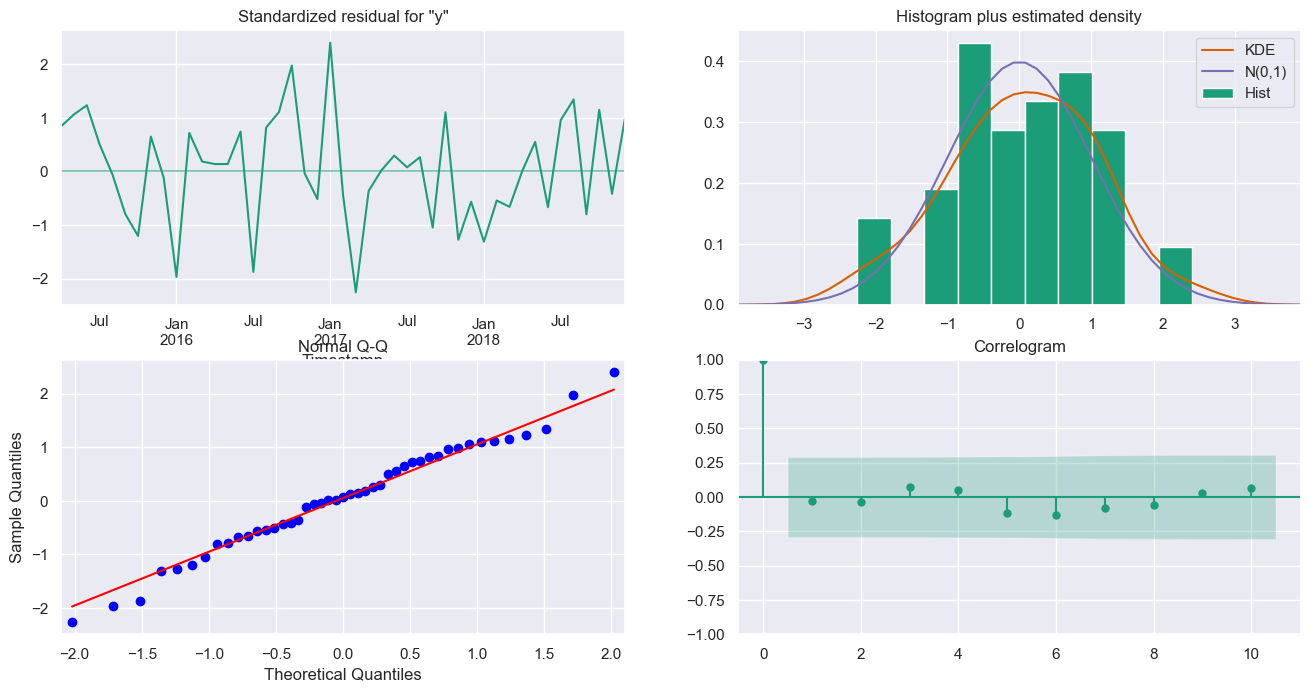

In [31]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

    In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

    The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

    The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.


## Forecasting with SARIMAX

**Prediction for overall crime in Baltimore City**

In [32]:
y_test.index[-1], y_test.index[0]

(Timestamp('2020-12-01 00:00:00+0000', tz='UTC', freq='MS'),
 Timestamp('2019-01-01 00:00:00+0000', tz='UTC', freq='MS'))

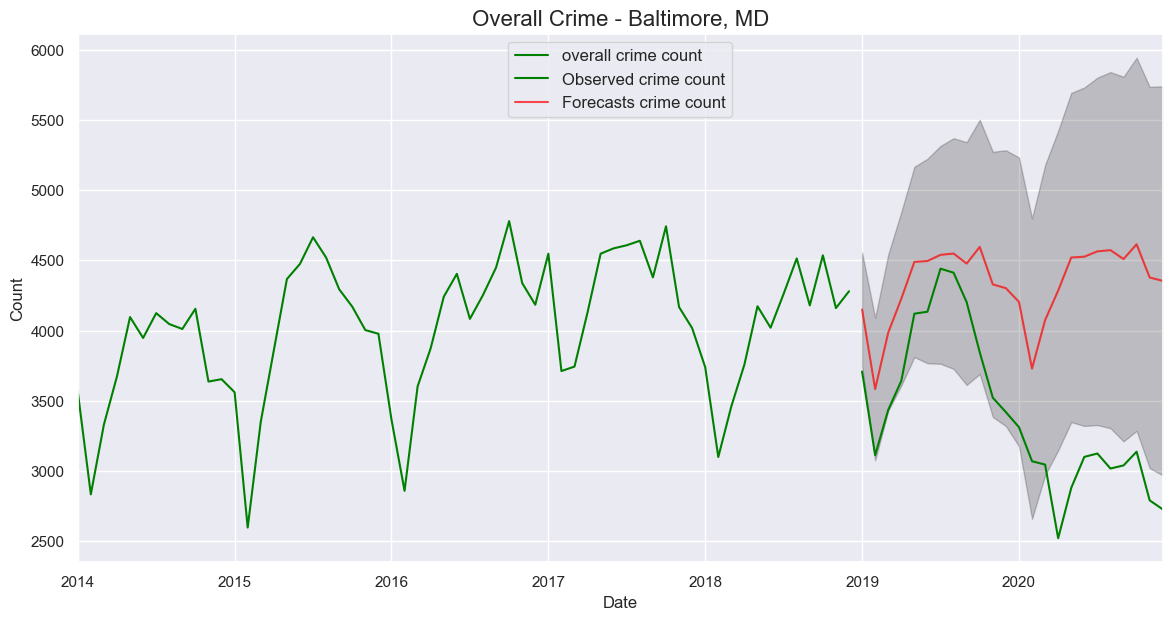

Wall time: 1.19 s


In [33]:
%%time
# Predictions on test set. 

# Setting dynamic = True so that the model won't use actual values for prediction. Basically the model will use
# the lag terms and moving average terms of the already forecasted values. So, we will see the errors 
#(confidence interval) increasing with each forecast.
#Forecasting 2 years steps ahead
pred = results.get_prediction(start=y_test.index[0], end=y_test.index[-1], 
                              dynamic=True)

#Confidence intervals of the forecasted values
pred_ci = pred.conf_int()

#Plot the data
ax = y_train.plot(figsize = (14, 7), label='overall crime count', legend = True, color='g')
y_test.plot(ax=ax, label='Observed crime count', figsize= (14,7), color='g')
#Plot the forecasted values 
pred.predicted_mean.plot(ax=ax, label='Forecasts crime count', figsize = (14, 7), alpha=.7, color='r')

#Plot the confidence intervals
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.title('Overall Crime - Baltimore, MD', size = 16)
plt.ylabel('Count', size=12)
plt.xlabel('Date', size=12)
plt.legend(loc='upper center', prop={'size': 12})

plt.show()

#### The SARIMAX model prediction was way off the observed crime count. Therefore, **fbProphet** which is a more powerful time series package was used. 

#### The prophet model will be trained on train and the overall dataset

## Time Series Modeling with fbProphet

#### Using the whole dataset without splitting into test and train

##### Prepare the time series for fbProphet forecasting

In [34]:
dd = resampled(crime)
dd = pd.DataFrame(dd, columns=['count'])
dd.head(5)

count
Timestamp                       
2014-01-01 00:00:00+00:00   3566
2014-02-01 00:00:00+00:00   2832
2014-03-01 00:00:00+00:00   3329
2014-04-01 00:00:00+00:00   3673
2014-05-01 00:00:00+00:00   4096

In [35]:
dd.columns


Index(['count'], dtype='object')

In [36]:
#rename column name from count to y
dd= dd.rename(columns={'count':'y'})
#rename the time series index from Timestamp to ds
dd.rename_axis('ds', inplace=True)


#### Columns name where renamed because Prophet requires columns ds (Date) and y (value)

In [37]:
dd.head(3)

y
ds                             
2014-01-01 00:00:00+00:00  3566
2014-02-01 00:00:00+00:00  2832
2014-03-01 00:00:00+00:00  3329

In [38]:
#reset index to have columns ds and y
ddf = dd.reset_index()
#Remove timezone from the ds column
ddf['ds'] = ddf['ds'].dt.tz_convert(None)

### Forecasting with fbProphet

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 23.2 s


Text(0.5, 1.0, 'Overall Crime')

<Figure size 1500x600 with 0 Axes>

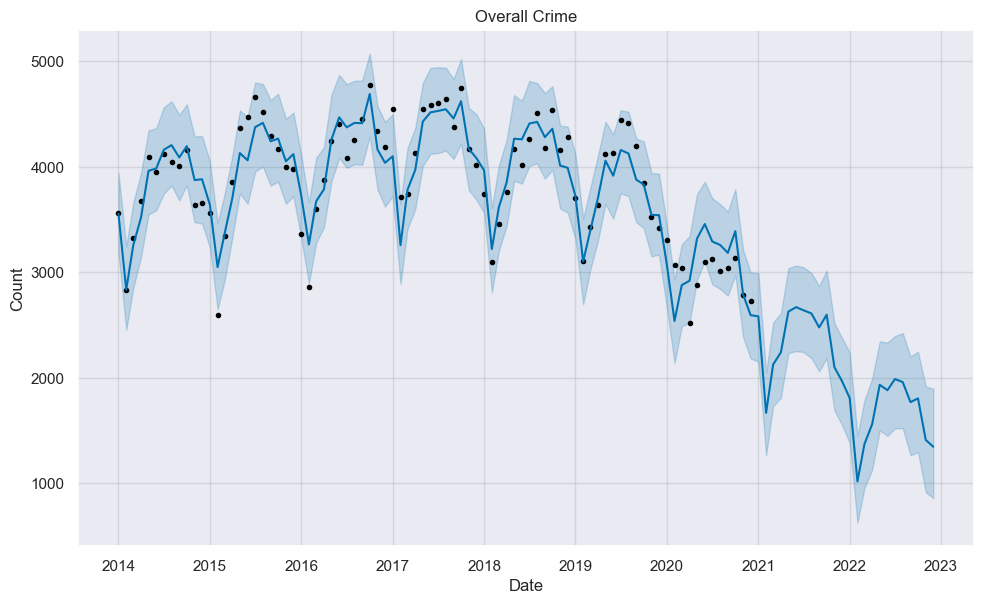

In [39]:
%%time
from fbprophet import Prophet
# Make the prophet model and fit on the data
dd_model = Prophet(interval_width=0.95)
dd_model.fit(ddf)
# Make a future dataframe for 3 years
dd_forecast = dd_model.make_future_dataframe(periods=24, freq='MS')
# Make predictions
dd_forecast = dd_model.predict(dd_forecast)
plt.figure(figsize=(15, 6))
dd_model.plot(dd_forecast, xlabel = 'Date', ylabel = 'Count')
plt.title('Overall Crime');

The black dots represent the actual values (notice how they stop at the end of 2020), the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty (always a critical part of any prediction). The region of uncertainty increases the further out in the future the prediction is made because initial uncertainty propagates and grows over time. This is observed in crime forecasts which get less accurate the further out in time they are made.

The result from the fbProphet prediction shows that the model fit perfectly which reveals the decreasing trend of the crime after 2017 which matches the decreased treend that occurs in the observed crime count. 

Fbprophet provides a plot_component() function that can be used to visualize the overall trend and components of the time series.

fbProphet model forecast for the overall crime in Baltimore city, MD

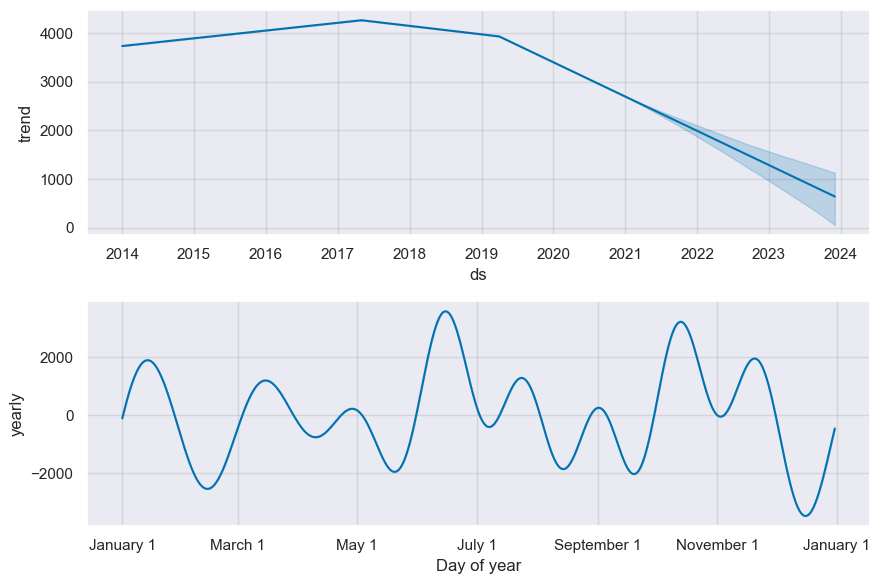

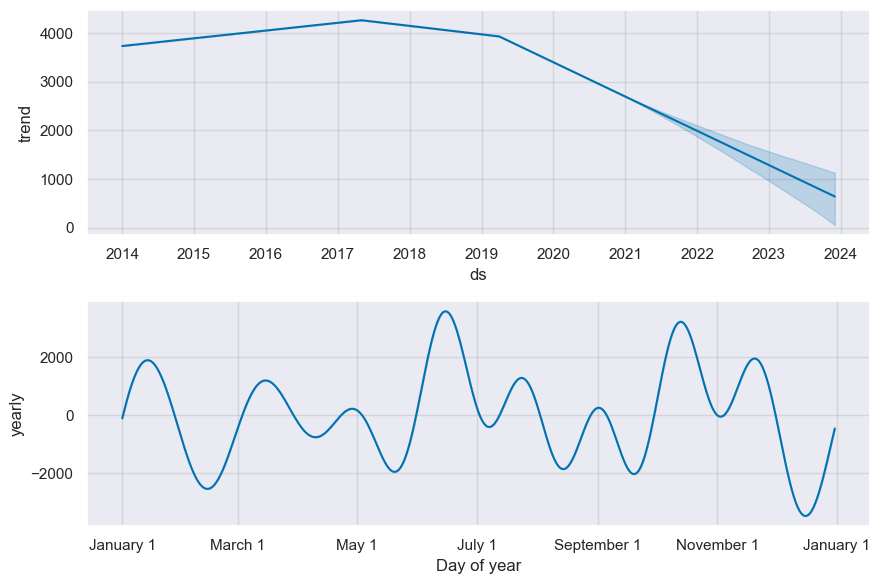

In [94]:
dd_model.plot_components(dd_forecast)

### Forecasting with prophet

#### Using splt dataset- train and test

In [40]:
y_train.shape, y_test.shape

((60,), (24,))

In [41]:

dd_train = pd.DataFrame(y_train, columns=['count'])

dd_test = pd.DataFrame(y_test, columns=['count'])

In [42]:
#rename column name from count to y
dd_train= dd_train.rename(columns={'count':'y'})
#rename the time series index from Timestamp to ds
dd_train.rename_axis('ds', inplace=True)

#rename column name from count to y
dd_test= dd_test.rename(columns={'count':'y'})
#rename the time series index from Timestamp to ds
dd_test.rename_axis('ds', inplace=True)


In [43]:
#reset index to have columns ds and y
ddf_train = dd_train.reset_index()
ddf_test = dd_test.reset_index()
#Remove timezone from the ds column
ddf_train['ds'] = ddf_train['ds'].dt.tz_convert(None)
ddf_test['ds'] = ddf_test['ds'].dt.tz_convert(None)

In [44]:
ddf_train.shape, ddf_test.shape

((60, 2), (24, 2))

<Figure size 1500x600 with 0 Axes>

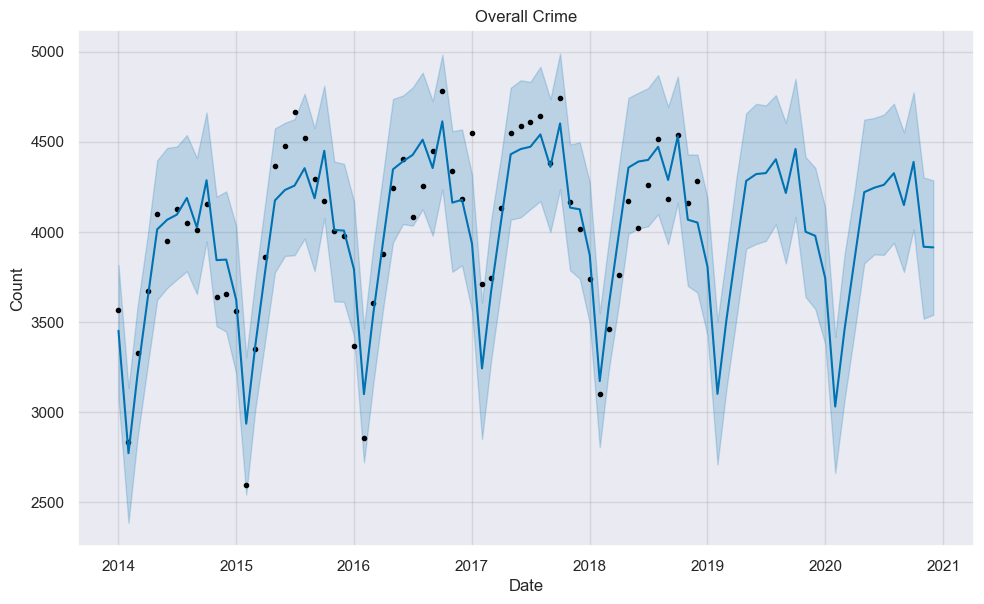

In [45]:
# Make the prophet model and fit on the data
model = Prophet(daily_seasonality=False,
                   weekly_seasonality=False,
                   yearly_seasonality=False,
                   interval_width=0.95
                  ).add_seasonality(name='yearly', period=365.25, fourier_order=5)
model.fit(ddf_train)
# Make a future dataframe having 24 months (test data count)
future = model.make_future_dataframe(periods=24, freq='MS') #test data count
# Make predictions
forecast = model.predict(future)
plt.figure(figsize=(15, 6))
model.plot(forecast, xlabel = 'Date', ylabel = 'Count')
plt.title('Overall Crime');

Fbprophet provides a plot_component() function that can be used to visualize the overall trend and components of the time series.

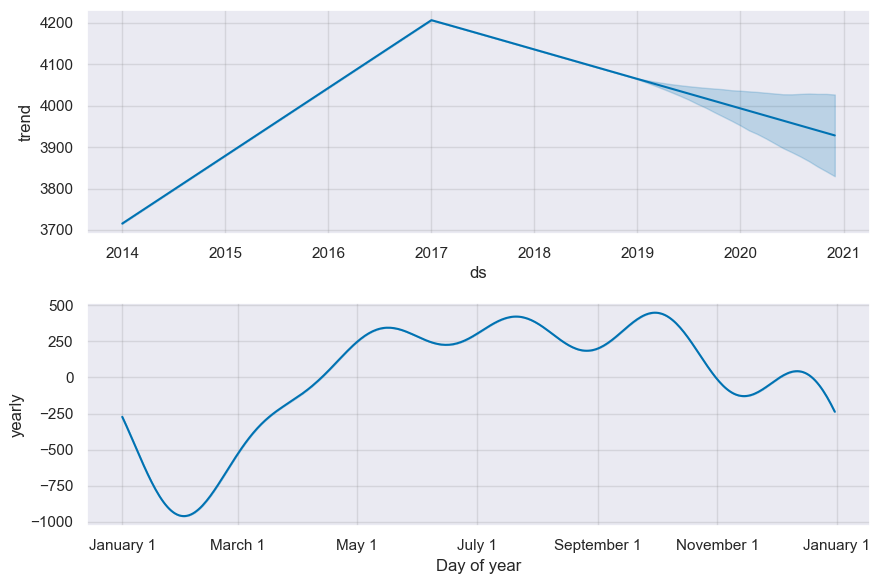

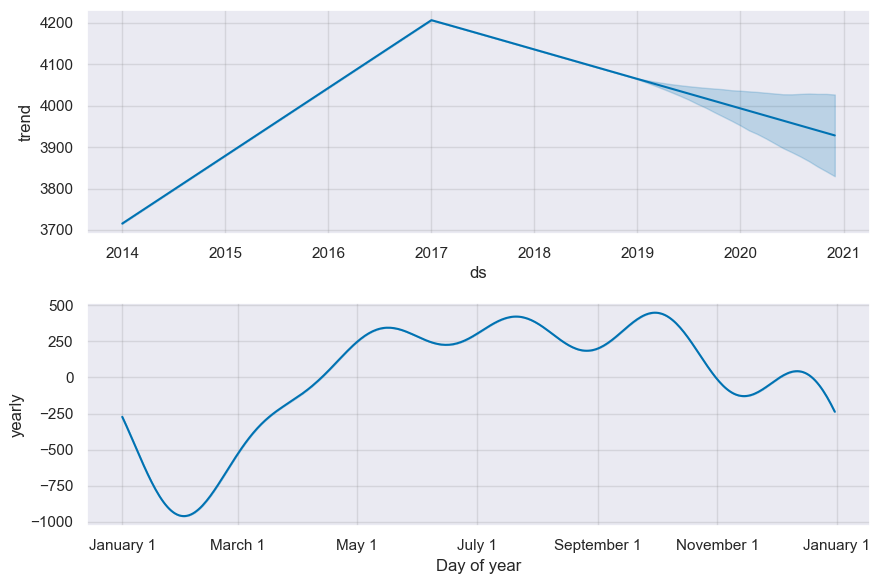

In [46]:
model.plot_components(forecast)

If we compare the above graph with the actual data, they both seems to be pretty similar to each other. Hence the model is working well.

Predict with the test

<Figure size 1500x600 with 0 Axes>

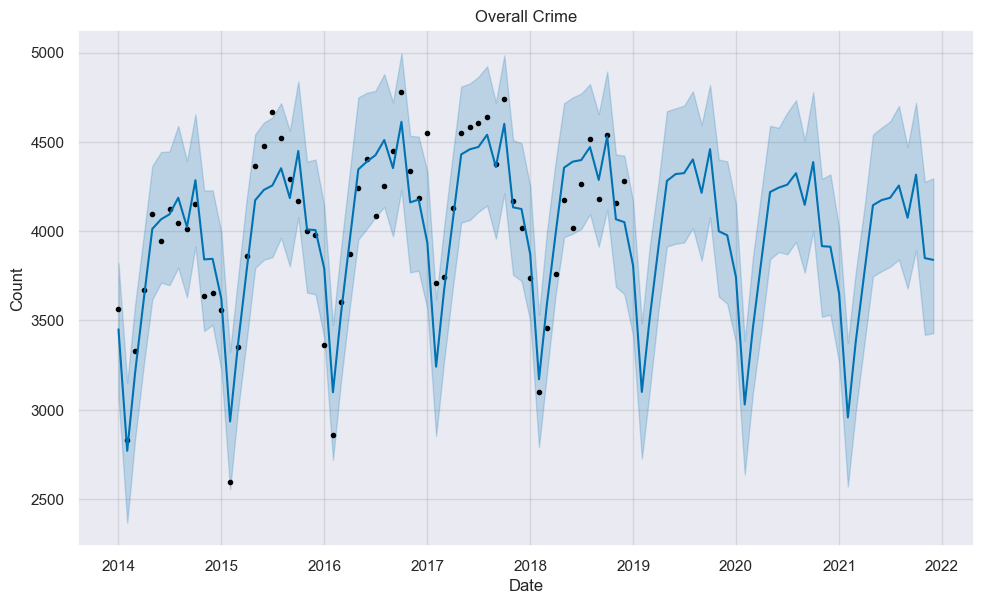

In [47]:
future1 = model.make_future_dataframe(periods=36, freq='MS') #test data count + extra 12 months
# Make predictions
forecast1 = model.predict(future1)
plt.figure(figsize=(15, 6))
model.plot(forecast1, xlabel = 'Date', ylabel = 'Count')
plt.title('Overall Crime');

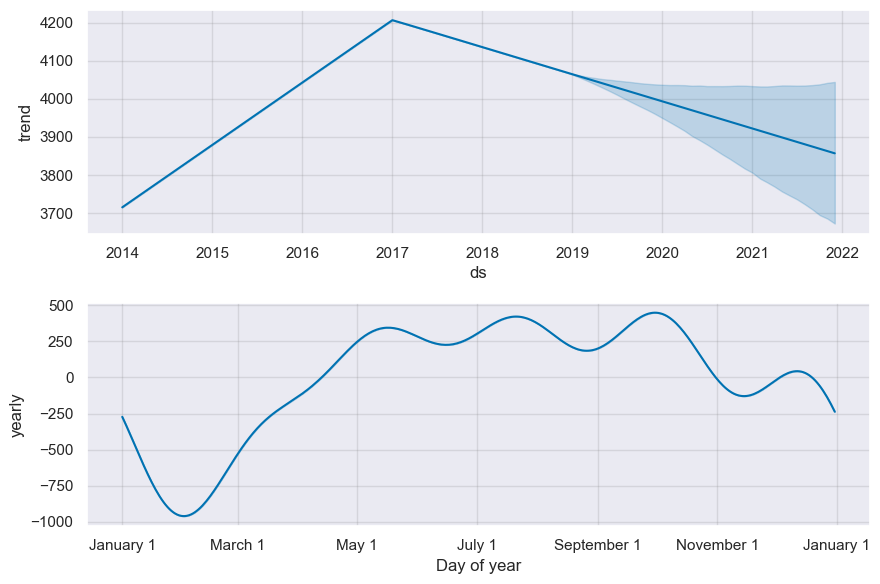

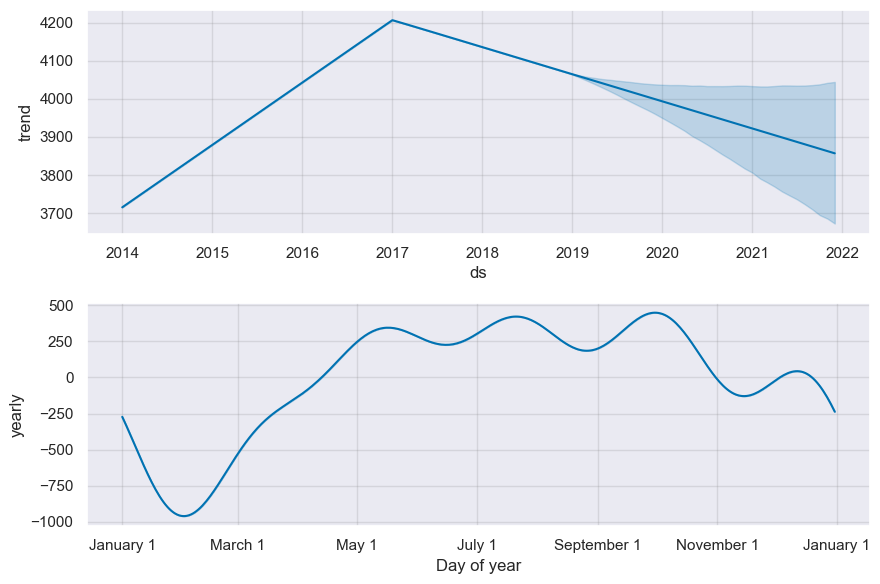

In [48]:
model.plot_components(forecast1)

The model using the train and test still reveals the decreasing trend 

## Forecasting the trends for the individual dataframes 

### decomposition of the individual crime types

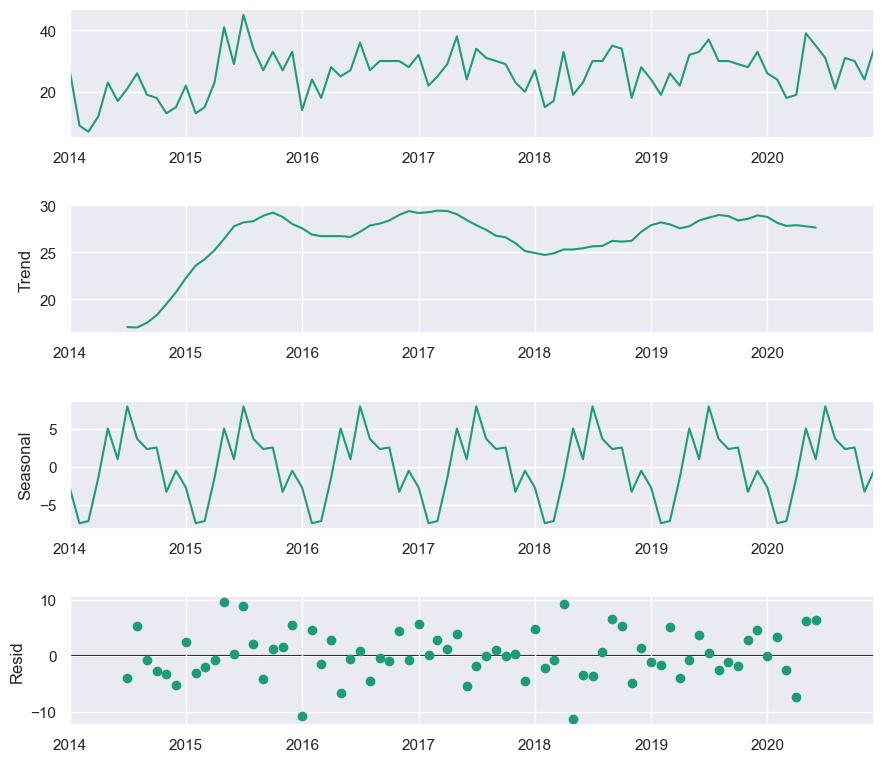

In [57]:
decompose_dataframe(homicide)

Time Series is Stationary


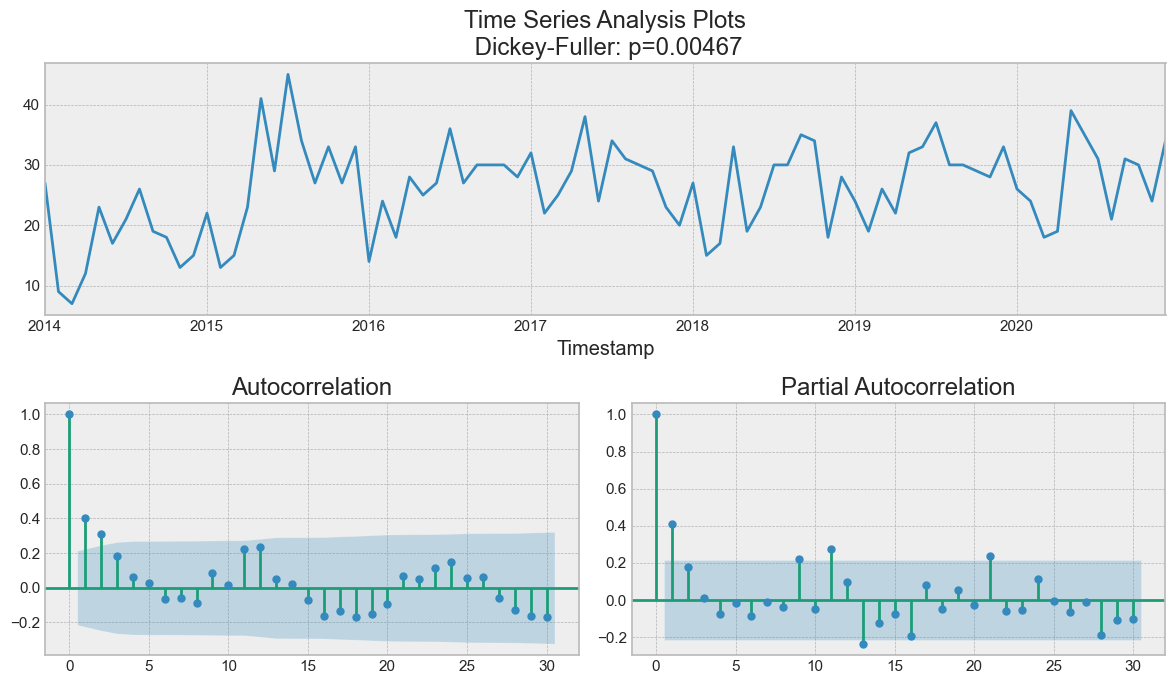

In [58]:
# test for stationarity of the data
tsplot(resampled(homicide), lags=30)


In [64]:
def forecast_prophet(df, title):
    dd = resampled(df)
    dd = pd.DataFrame(dd, columns=['count'])
    #rename column name from count to y
    dd= dd.rename(columns={'count':'y'})
    #rename the time series index from Timestamp to ds
    dd.rename_axis('ds', inplace=True)
    #reset index to have columns ds and y
    ddf = dd.reset_index()
    #Remove timezone from the ds column
    ddf['ds'] = ddf['ds'].dt.tz_convert(None)
    # Make the prophet model and fit on the data
    model = Prophet(daily_seasonality=False,
                   weekly_seasonality=False,
                   yearly_seasonality=False,
                   interval_width=0.95
                  ).add_seasonality(name='yearly', period=365.25, fourier_order=5)
    model.fit(ddf)
    # Make a future dataframe having 24 months (test data count)
    future = model.make_future_dataframe(periods=24, freq='MS') #test data count
    # Make predictions
    forecast = model.predict(future)
    plt.figure(figsize=(15, 6))
    model.plot(forecast, xlabel = 'Date', ylabel = 'Count')
    plt.title(title);

In [65]:
def components_prophet(df):
    dd = resampled(df)
    dd = pd.DataFrame(dd, columns=['count'])
    #rename column name from count to y
    dd= dd.rename(columns={'count':'y'})
    #rename the time series index from Timestamp to ds
    dd.rename_axis('ds', inplace=True)
    #reset index to have columns ds and y
    ddf = dd.reset_index()
    #Remove timezone from the ds column
    ddf['ds'] = ddf['ds'].dt.tz_convert(None)
    # Make the prophet model and fit on the data
    model = Prophet(daily_seasonality=False,
                   weekly_seasonality=False,
                   yearly_seasonality=False,
                   interval_width=0.95
                  ).add_seasonality(name='yearly', period=365.25, fourier_order=5)
    model.fit(ddf)
    # Make a future dataframe having 24 months (test data count)
    future = model.make_future_dataframe(periods=24, freq='MS') #test data count
    # Make predictions
    forecast = model.predict(future)
    #plt.figure(figsize=(15, 6))
    #model.plot(forecast, xlabel = 'Date', ylabel = 'Count')
    model.plot_components(forecast)
    #plt.title('Overall Crime');

<Figure size 1500x600 with 0 Axes>

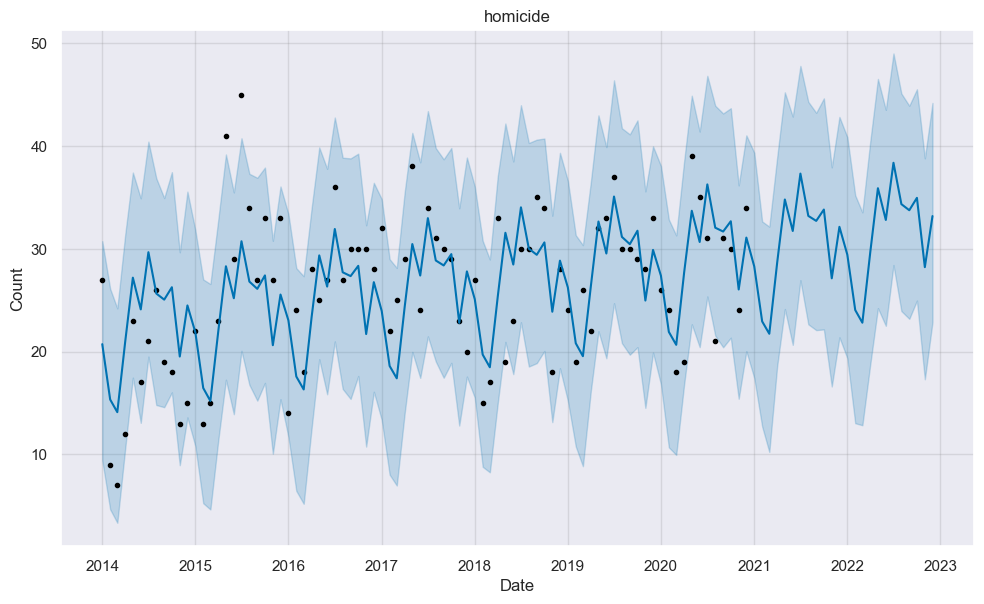

In [67]:
forecast_prophet(homicide, 'homicide')

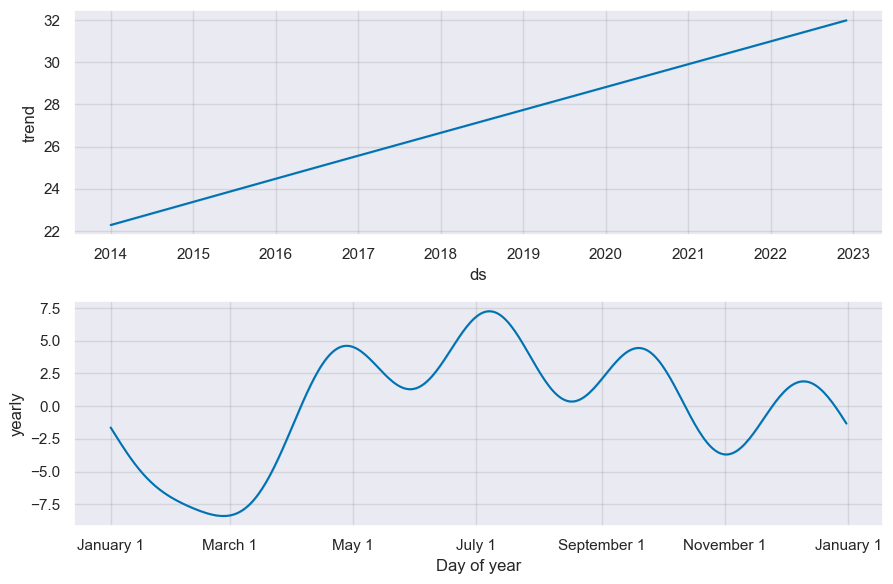

In [115]:
components_prophet(homicide)

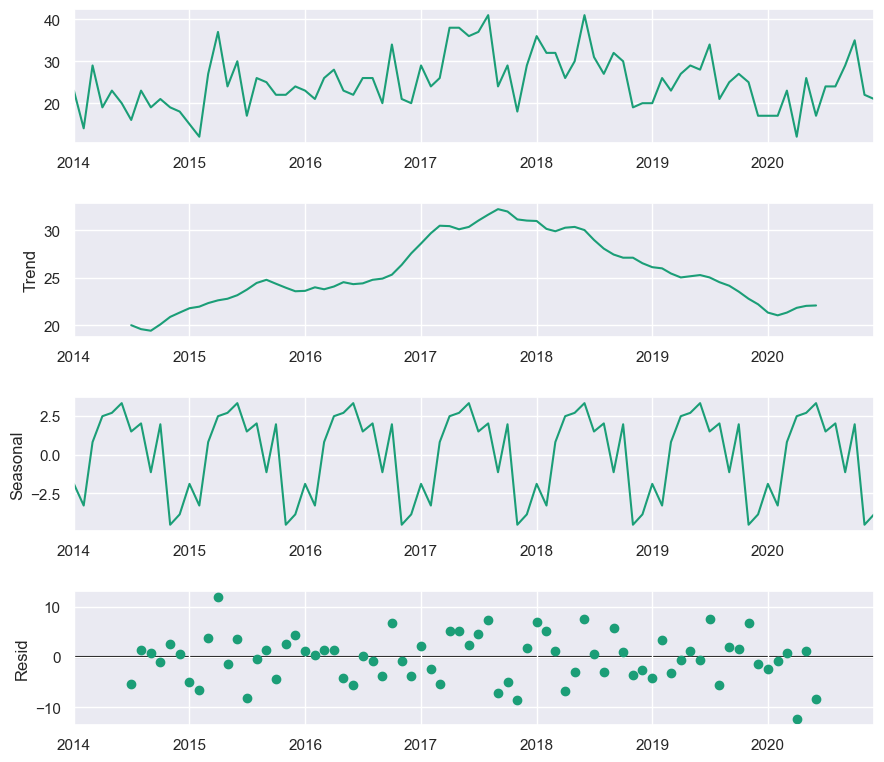

In [68]:
decompose_dataframe(rape)

Time Series is Stationary


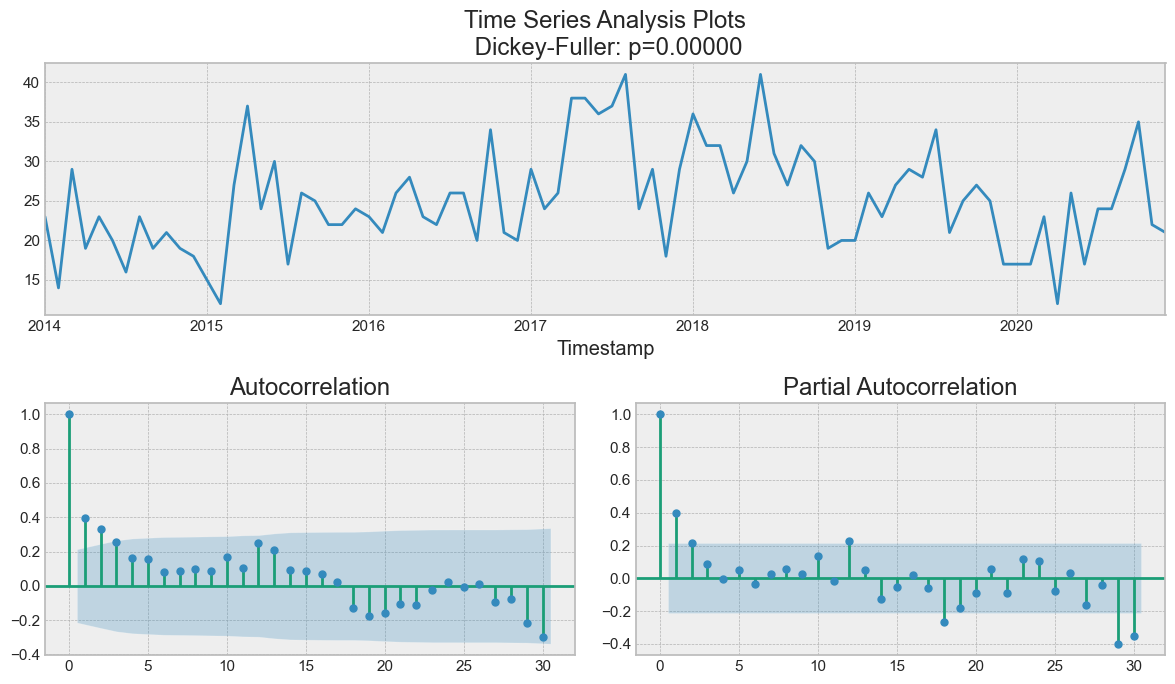

In [69]:
# test for stationarity of overall data
tsplot(resampled(rape), lags=30)


<Figure size 1500x600 with 0 Axes>

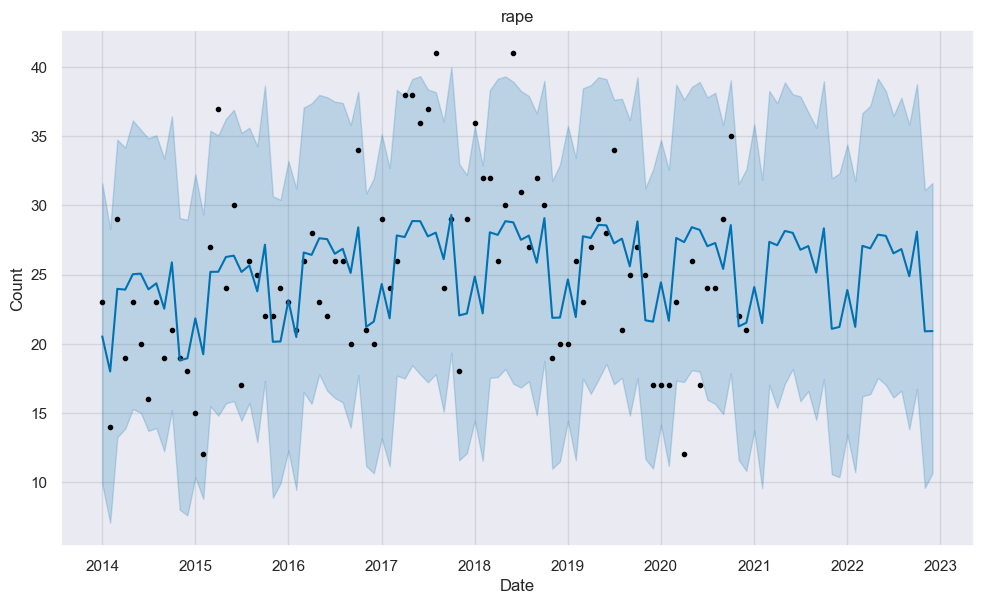

In [70]:
forecast_prophet(rape, 'rape')

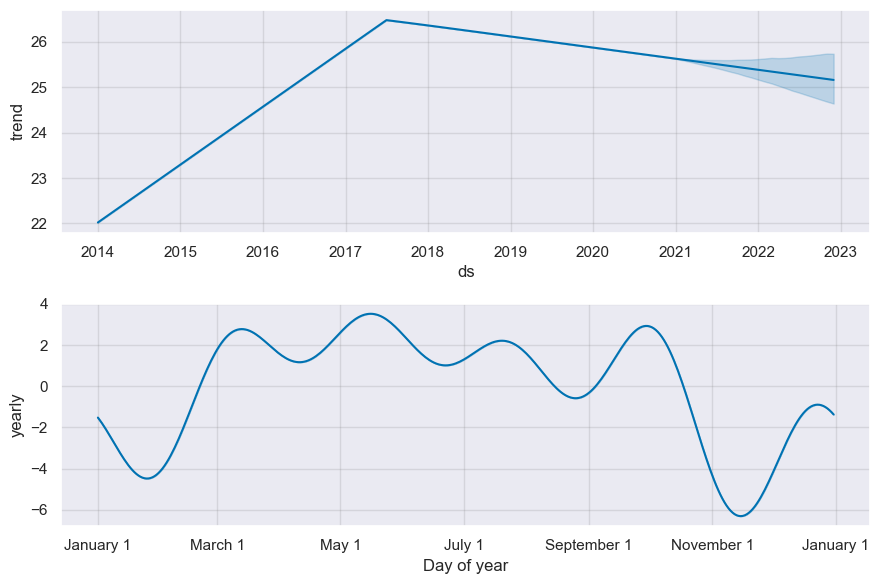

In [71]:
components_prophet(rape)

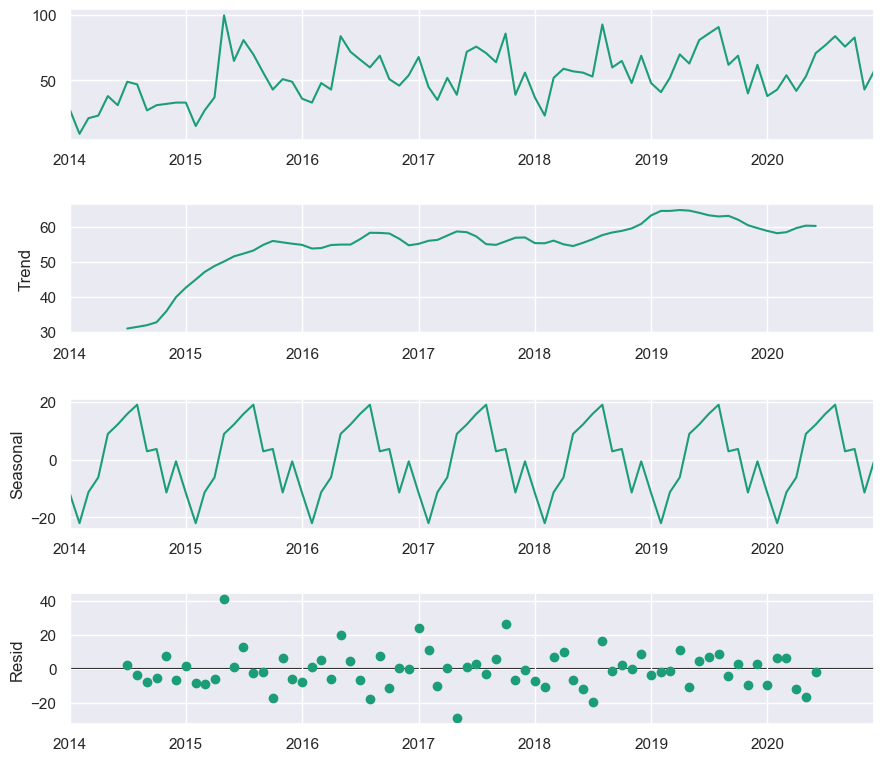

In [73]:
decompose_dataframe(shooting)

Time Series is Stationary


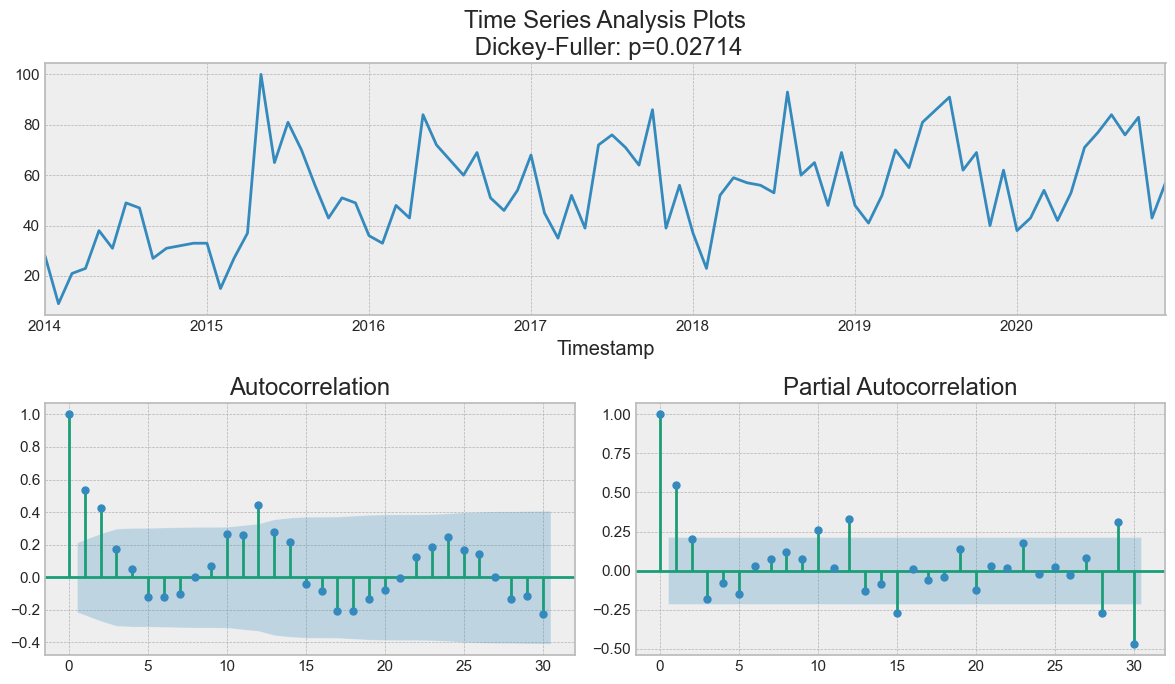

In [74]:
# test for stationarity of overall data
tsplot(resampled(shooting), lags=30)


<Figure size 1500x600 with 0 Axes>

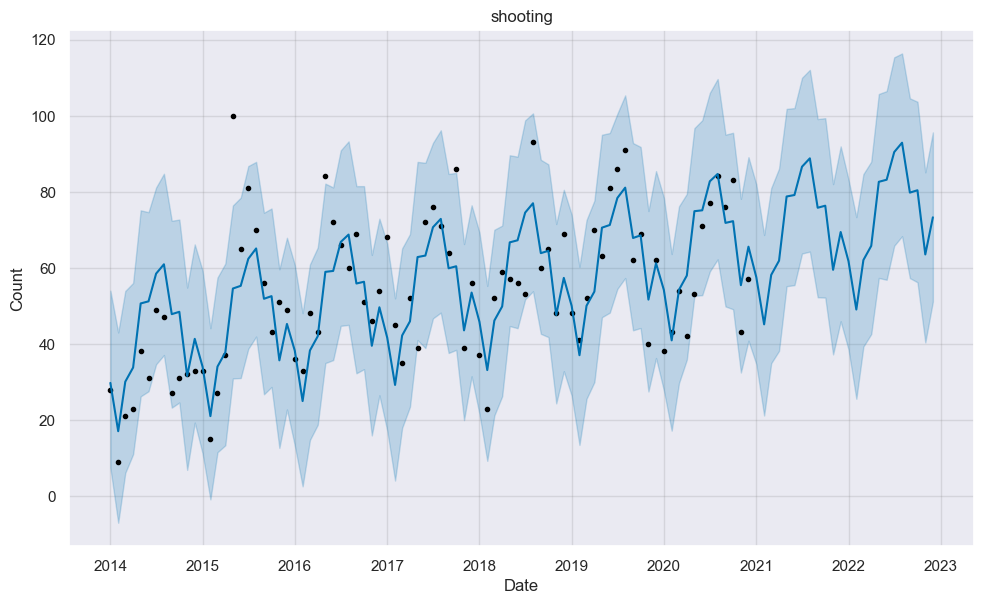

In [75]:
forecast_prophet(shooting, 'shooting')

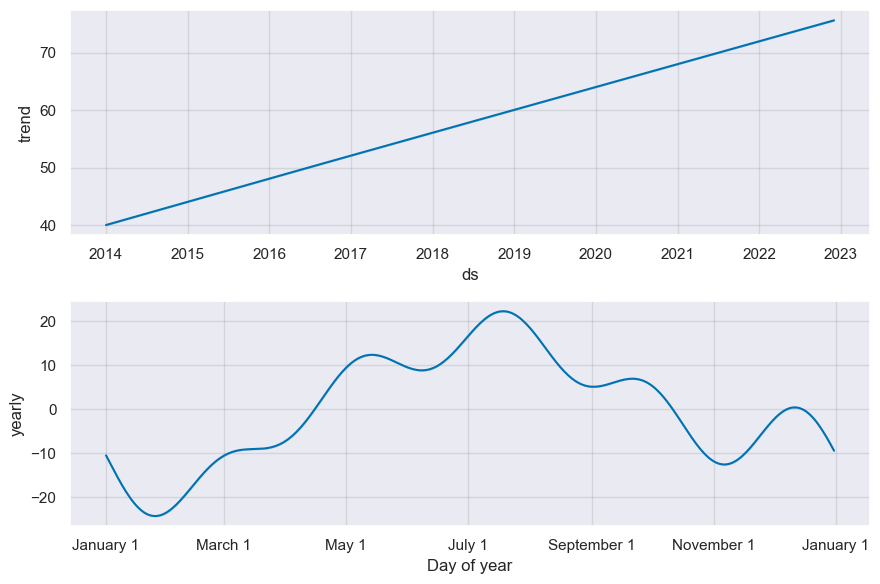

In [76]:
components_prophet(shooting)

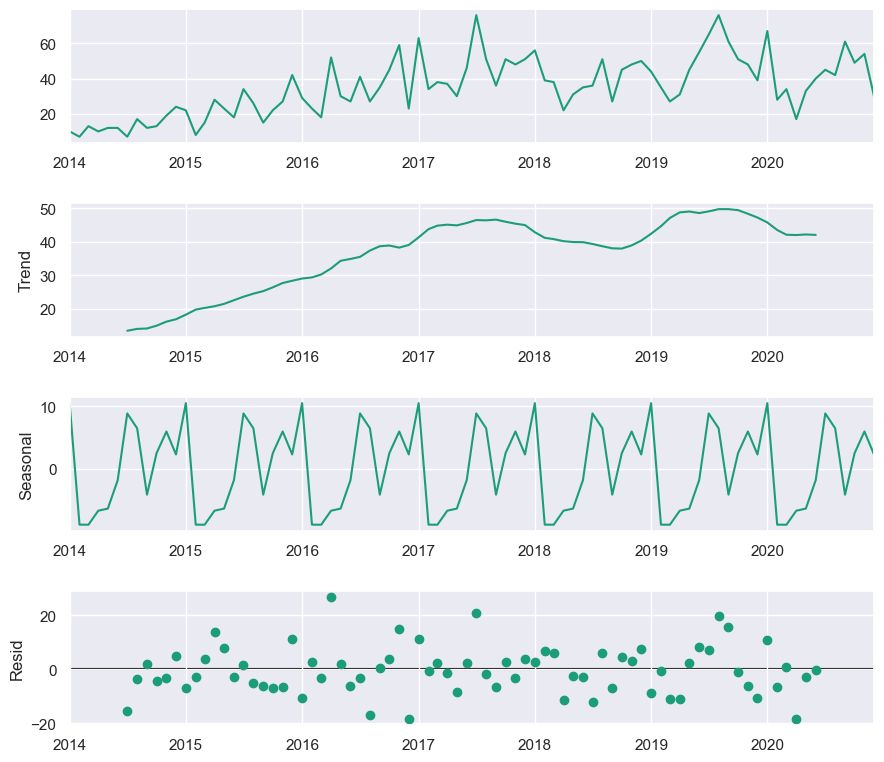

In [77]:
decompose_dataframe(carjack)

Time Series is Stationary


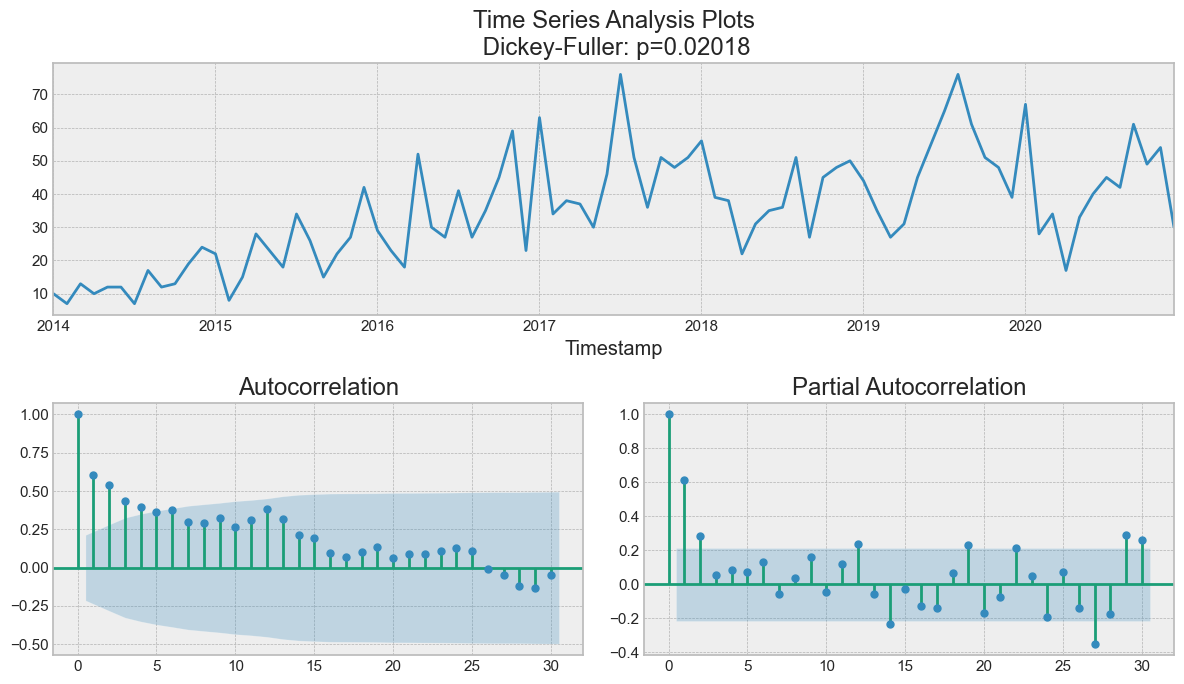

In [78]:
# test for stationarity of overall data
tsplot(resampled(carjack), lags=30)


<Figure size 1500x600 with 0 Axes>

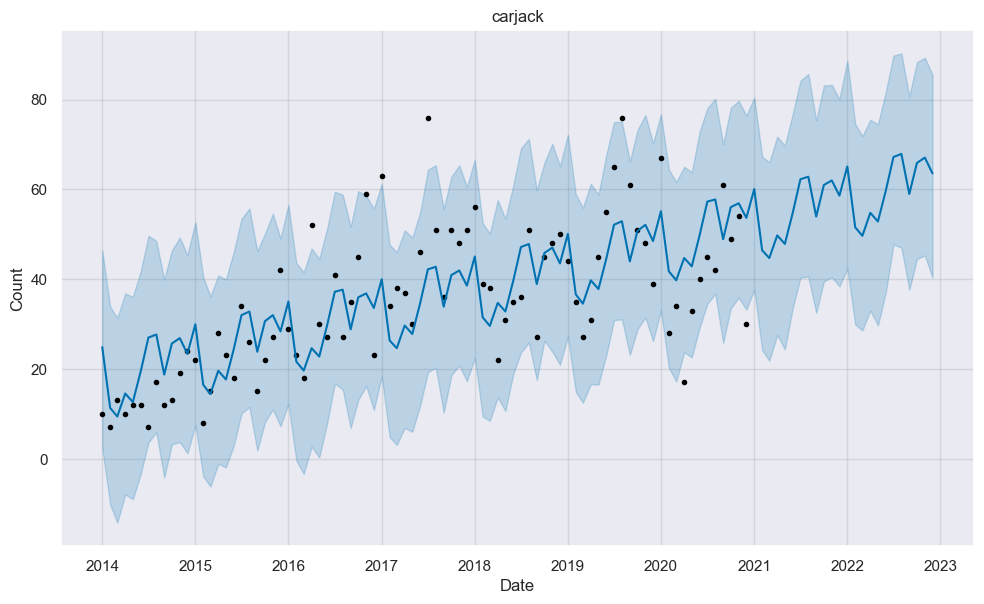

In [79]:
forecast_prophet(carjack, 'carjack')

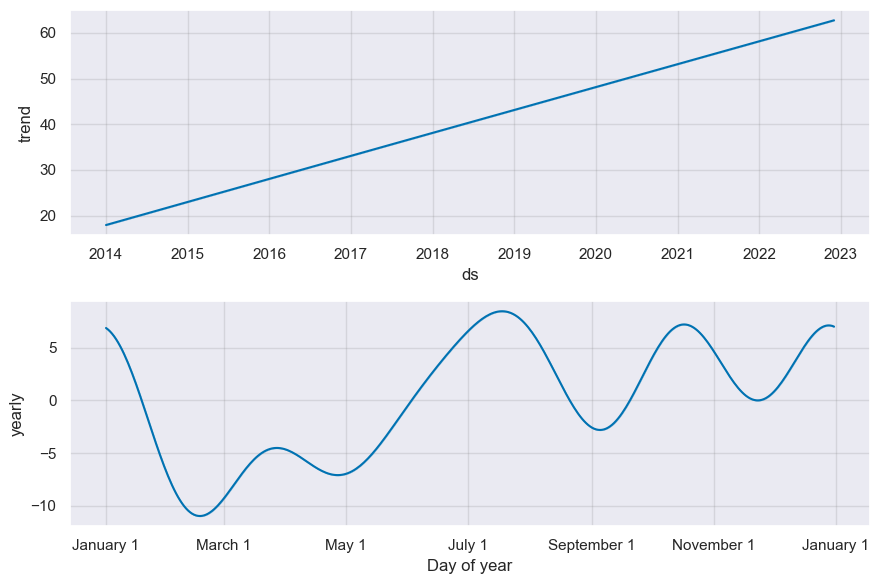

In [80]:
components_prophet(carjack)

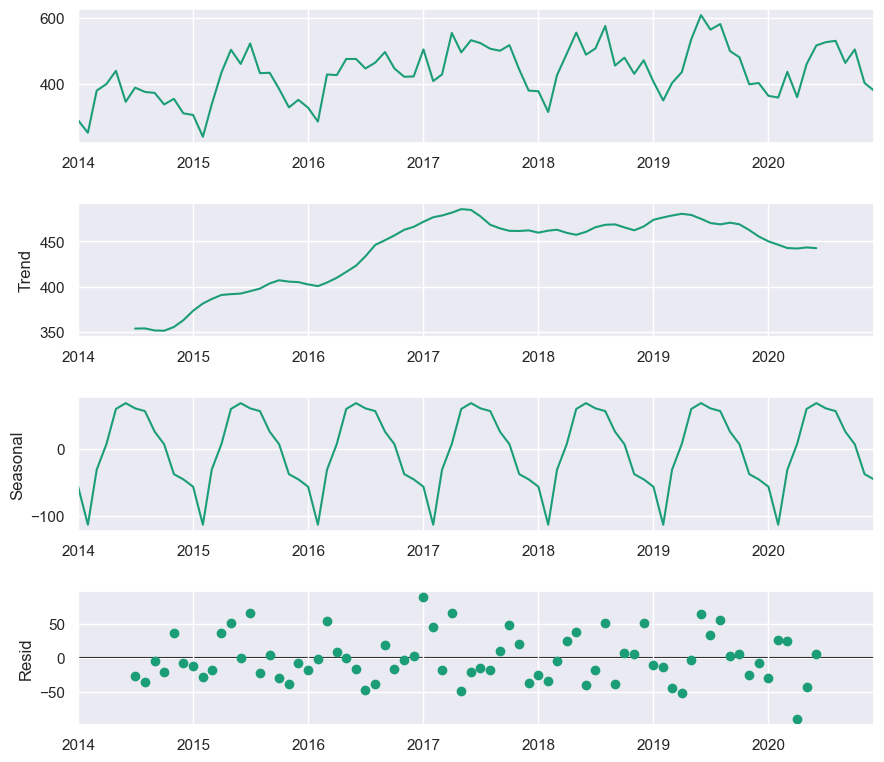

In [81]:
decompose_dataframe(assault)

Time Series is NOT Stationary


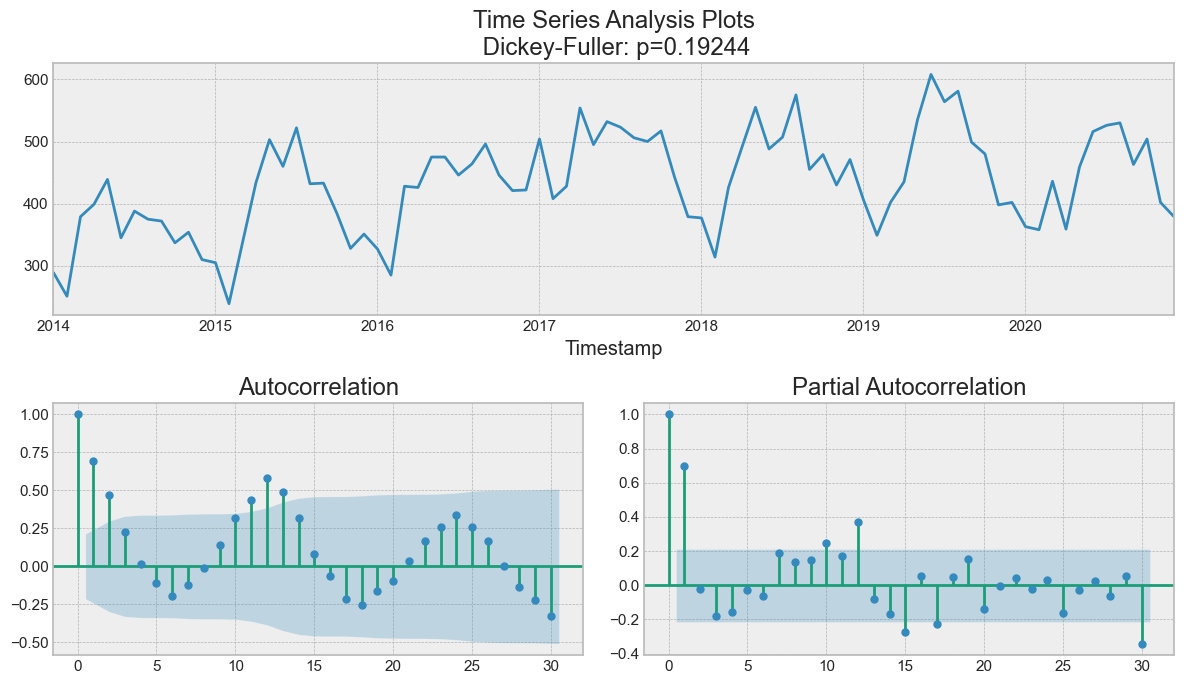

In [82]:
# test for stationarity of overall data
tsplot(resampled(assault), lags=30)


<Figure size 1500x600 with 0 Axes>

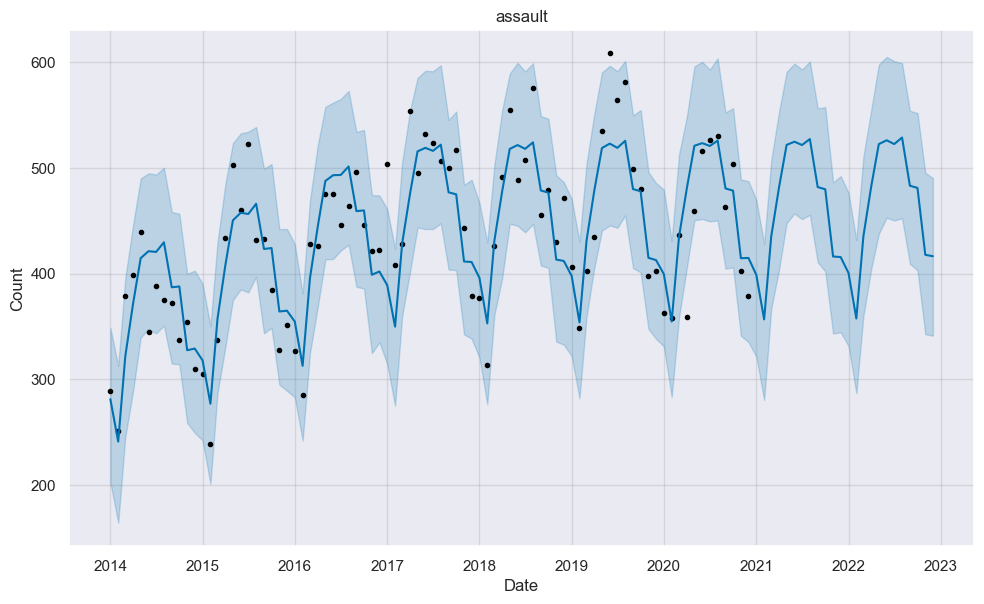

In [83]:
forecast_prophet(assault, 'assault')

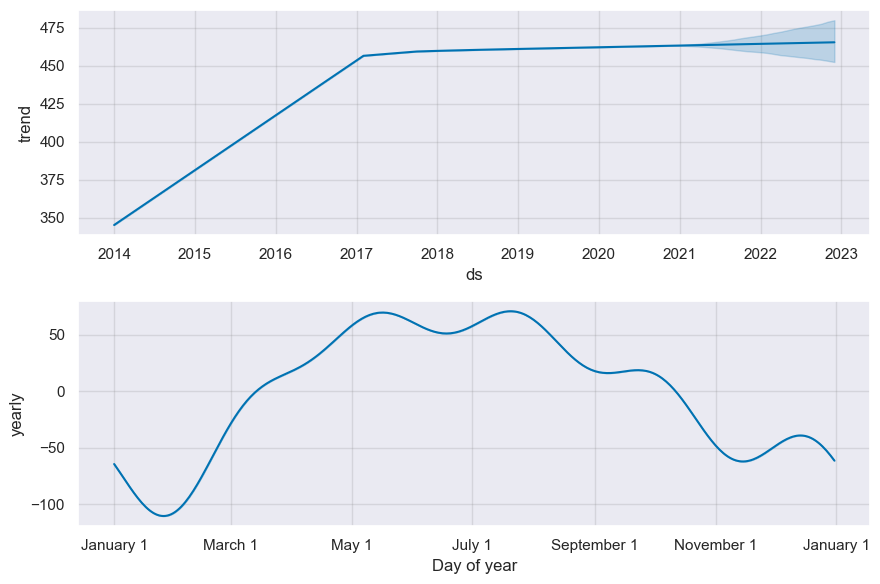

In [84]:
components_prophet(assault)

## fbProphet Results

___

For each of the individual crime types investigated. The fbProphet model reveals a steady increasing trend for **homicide** with the highest crime count occurring in July. Homicide increased steadily with the highest crime count occuring during the summer (July) and the lowest around spring (March). The observed increasing trend will continue through 2023.

**Shooting** has a similar increasing trend as homicide which strongly suggest a correlation between the two crime types. The highest crime count also occurs in July with the lowest occuring around February/March. 

**Rape** shows sharp increase from 2014 to the highest count in 2017 before beginning a gradual decreasing trend. This model reveals that rape will continue to decrease steadily. Most of reported rape cases is expected to occur between March and November which suggest warmer weather influence this crime type.

**Carjacking** is a crime of concern in Baltimore city because of the increasing trends and the fluctuating nature where the crime count goes up and down throughout the year. Highest carjacking is expected to occur around July, November and January.

**Agg. assault** increases steadily untill 2017 where the crime experiences the highest count. This crime type count  will remain constant untill 2023. 



## Conclusions

In summary, the overall crime in Baltimore City, MD is projected to follow a decreasing trend, with the highest occurrence between May and October. On the other hand, homicide and shooting will increase steadily and agg. assault remaining constant. The only crime type that shows a decreasing trend is rape.